<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [2]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [5]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [7]:
# print(config_tickers.DOW_30_TICKER)

In [8]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [10]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [11]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [12]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [13]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [14]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [15]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [16]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [18]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)

## Environment for Training



In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [20]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [62]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [50]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [51]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=6000000)

Logging to ppo/1_2
----------------------------------
| time/              |           |
|    fps             | 113       |
|    iterations      | 1         |
|    time_elapsed    | 18        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.7089172 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 2           |
|    time_elapsed         | 37          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015674507 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0239     |
|    learning_rate        | 0.00025     |
|    loss                 | 8.51        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0182 

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 12          |
|    time_elapsed         | 230         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.020878986 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.6       |
|    explained_variance   | -0.00445    |
|    learning_rate        | 0.00025     |
|    loss                 | 9.14        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0195     |
|    reward               | 0.19243628  |
|    std                  | 1.02        |
|    value_loss           | 25.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 13    

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 22         |
|    time_elapsed         | 421        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.0228916  |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42        |
|    explained_variance   | -0.0159    |
|    learning_rate        | 0.00025    |
|    loss                 | 12.5       |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.0165    |
|    reward               | 0.31981114 |
|    std                  | 1.03       |
|    value_loss           | 31.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 23          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 32          |
|    time_elapsed         | 611         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.028351089 |
|    clip_fraction        | 0.312       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.5       |
|    explained_variance   | 0.0044      |
|    learning_rate        | 0.00025     |
|    loss                 | 13.7        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0194     |
|    reward               | -0.03902703 |
|    std                  | 1.05        |
|    value_loss           | 30          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 33 

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 42          |
|    time_elapsed         | 802         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.050841734 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | -0.00521    |
|    learning_rate        | 0.00025     |
|    loss                 | 21.4        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00701    |
|    reward               | 0.15137213  |
|    std                  | 1.07        |
|    value_loss           | 90.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 43    

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 52          |
|    time_elapsed         | 992         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.031559117 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.00941     |
|    learning_rate        | 0.00025     |
|    loss                 | 59          |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.013      |
|    reward               | -3.3073916  |
|    std                  | 1.09        |
|    value_loss           | 112         |
-----------------------------------------
day: 2892, episode: 1100
begin_total_asset: 1000000.00
end_total_asset: 6510891.58
total_reward: 5510891.58
total_cost: 285004.65
total_trades: 74261
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 62          |
|    time_elapsed         | 1181        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.021719757 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.0836      |
|    learning_rate        | 0.00025     |
|    loss                 | 107         |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.000624   |
|    reward               | 4.9674025   |
|    std                  | 1.11        |
|    value_loss           | 175         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 63    

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 72         |
|    time_elapsed         | 1370       |
|    total_timesteps      | 147456     |
| train/                  |            |
|    approx_kl            | 0.02942952 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.8      |
|    explained_variance   | 0.356      |
|    learning_rate        | 0.00025    |
|    loss                 | 70.9       |
|    n_updates            | 710        |
|    policy_gradient_loss | -0.00159   |
|    reward               | -26.454447 |
|    std                  | 1.13       |
|    value_loss           | 95.6       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 73          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 82          |
|    time_elapsed         | 1558        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.013957405 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.2       |
|    explained_variance   | 0.217       |
|    learning_rate        | 0.00025     |
|    loss                 | 40.3        |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.0065     |
|    reward               | -0.09901426 |
|    std                  | 1.15        |
|    value_loss           | 131         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 83    

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 92         |
|    time_elapsed         | 1748       |
|    total_timesteps      | 188416     |
| train/                  |            |
|    approx_kl            | 0.0176704  |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -45.5      |
|    explained_variance   | 0.155      |
|    learning_rate        | 0.00025    |
|    loss                 | 18.5       |
|    n_updates            | 910        |
|    policy_gradient_loss | -0.012     |
|    reward               | -1.4198929 |
|    std                  | 1.16       |
|    value_loss           | 43.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 93          |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 102        |
|    time_elapsed         | 1940       |
|    total_timesteps      | 208896     |
| train/                  |            |
|    approx_kl            | 0.02435002 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -46        |
|    explained_variance   | 0.155      |
|    learning_rate        | 0.00025    |
|    loss                 | 93.3       |
|    n_updates            | 1010       |
|    policy_gradient_loss | -0.00952   |
|    reward               | -1.6037109 |
|    std                  | 1.18       |
|    value_loss           | 131        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 103         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 112         |
|    time_elapsed         | 2129        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.030606706 |
|    clip_fraction        | 0.292       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.5       |
|    explained_variance   | 0.0626      |
|    learning_rate        | 0.00025     |
|    loss                 | 152         |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.00791    |
|    reward               | -1.6134235  |
|    std                  | 1.2         |
|    value_loss           | 145         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 113      

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 122         |
|    time_elapsed         | 2320        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.023920154 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.9       |
|    explained_variance   | 0.0621      |
|    learning_rate        | 0.00025     |
|    loss                 | 62.6        |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00756    |
|    reward               | 0.14565659  |
|    std                  | 1.22        |
|    value_loss           | 135         |
-----------------------------------------
day: 2892, episode: 1150
begin_total_asset: 1000000.00
end_total_asset: 7227035.78
total_reward: 6227035.78
total_cost: 259606.51
total_trades: 71022
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 132         |
|    time_elapsed         | 2520        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.038381714 |
|    clip_fraction        | 0.314       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.1       |
|    explained_variance   | 0.434       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.5        |
|    n_updates            | 1310        |
|    policy_gradient_loss | 0.00725     |
|    reward               | 1.5610416   |
|    std                  | 1.23        |
|    value_loss           | 31.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 133   

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 142        |
|    time_elapsed         | 2711       |
|    total_timesteps      | 290816     |
| train/                  |            |
|    approx_kl            | 0.03672291 |
|    clip_fraction        | 0.274      |
|    clip_range           | 0.2        |
|    entropy_loss         | -47.6      |
|    explained_variance   | 0.211      |
|    learning_rate        | 0.00025    |
|    loss                 | 21.8       |
|    n_updates            | 1410       |
|    policy_gradient_loss | 0.00397    |
|    reward               | -1.5591931 |
|    std                  | 1.25       |
|    value_loss           | 48.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 143         |
|    time_el

day: 2892, episode: 1170
begin_total_asset: 1000000.00
end_total_asset: 7100638.33
total_reward: 6100638.33
total_cost: 196861.85
total_trades: 64317
Sharpe: 0.944
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 152         |
|    time_elapsed         | 2923        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.028777253 |
|    clip_fraction        | 0.343       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.1       |
|    explained_variance   | 0.0872      |
|    learning_rate        | 0.00025     |
|    loss                 | 27          |
|    n_updates            | 1510        |
|    policy_gradient_loss | 0.00659     |
|    reward               | -1.6172957  |
|    std                  | 1.27        |
|    value_loss           | 79.8        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 162         |
|    time_elapsed         | 3119        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.018351482 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.5       |
|    explained_variance   | 0.11        |
|    learning_rate        | 0.00025     |
|    loss                 | 47.3        |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.0028     |
|    reward               | -0.6981484  |
|    std                  | 1.29        |
|    value_loss           | 122         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 163   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 172         |
|    time_elapsed         | 3308        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.015313614 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.8       |
|    explained_variance   | 0.207       |
|    learning_rate        | 0.00025     |
|    loss                 | 95.3        |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.00732    |
|    reward               | 3.409034    |
|    std                  | 1.31        |
|    value_loss           | 191         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 173   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 182         |
|    time_elapsed         | 3499        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.032646917 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.2       |
|    explained_variance   | 0.277       |
|    learning_rate        | 0.00025     |
|    loss                 | 70.7        |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.00101    |
|    reward               | -0.65165514 |
|    std                  | 1.32        |
|    value_loss           | 188         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 183   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 192         |
|    time_elapsed         | 3689        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.027962402 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.6       |
|    explained_variance   | 0.245       |
|    learning_rate        | 0.00025     |
|    loss                 | 39.4        |
|    n_updates            | 1910        |
|    policy_gradient_loss | 0.00219     |
|    reward               | -14.2857485 |
|    std                  | 1.34        |
|    value_loss           | 106         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 193   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 202         |
|    time_elapsed         | 3877        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.019027485 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.9       |
|    explained_variance   | 0.259       |
|    learning_rate        | 0.00025     |
|    loss                 | 34.8        |
|    n_updates            | 2010        |
|    policy_gradient_loss | 0.00099     |
|    reward               | -17.351904  |
|    std                  | 1.35        |
|    value_loss           | 108         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 203   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 212         |
|    time_elapsed         | 4067        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.011404158 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.4       |
|    explained_variance   | 0.382       |
|    learning_rate        | 0.00025     |
|    loss                 | 37.2        |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00145    |
|    reward               | 0.17390761  |
|    std                  | 1.38        |
|    value_loss           | 125         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 213   

day: 2892, episode: 1220
begin_total_asset: 1000000.00
end_total_asset: 5989812.63
total_reward: 4989812.63
total_cost: 155274.21
total_trades: 60717
Sharpe: 0.962
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 222          |
|    time_elapsed         | 4258         |
|    total_timesteps      | 454656       |
| train/                  |              |
|    approx_kl            | 0.018380795  |
|    clip_fraction        | 0.222        |
|    clip_range           | 0.2          |
|    entropy_loss         | -50.7        |
|    explained_variance   | 0.0168       |
|    learning_rate        | 0.00025      |
|    loss                 | 36.3         |
|    n_updates            | 2210         |
|    policy_gradient_loss | -0.00349     |
|    reward               | -0.032298118 |
|    std                  | 1.39         |
|    value_loss           | 91.5         |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 232         |
|    time_elapsed         | 4447        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.018791936 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.2       |
|    explained_variance   | 0.272       |
|    learning_rate        | 0.00025     |
|    loss                 | 115         |
|    n_updates            | 2310        |
|    policy_gradient_loss | -0.00608    |
|    reward               | 0.791627    |
|    std                  | 1.42        |
|    value_loss           | 160         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 233   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 242         |
|    time_elapsed         | 4637        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.020150831 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.6       |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.00025     |
|    loss                 | 77.2        |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.00308    |
|    reward               | 0.8839737   |
|    std                  | 1.43        |
|    value_loss           | 208         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 243   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 252         |
|    time_elapsed         | 4827        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.012375556 |
|    clip_fraction        | 0.0948      |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.8       |
|    explained_variance   | 0.701       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.1        |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.00518    |
|    reward               | 4.912503    |
|    std                  | 1.45        |
|    value_loss           | 33.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 253   

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 262        |
|    time_elapsed         | 5018       |
|    total_timesteps      | 536576     |
| train/                  |            |
|    approx_kl            | 0.04145121 |
|    clip_fraction        | 0.332      |
|    clip_range           | 0.2        |
|    entropy_loss         | -52.2      |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.00025    |
|    loss                 | 14.9       |
|    n_updates            | 2610       |
|    policy_gradient_loss | 0.00366    |
|    reward               | -2.2156405 |
|    std                  | 1.47       |
|    value_loss           | 37.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 263         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 272         |
|    time_elapsed         | 5222        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.032374904 |
|    clip_fraction        | 0.34        |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.6       |
|    explained_variance   | 0.359       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.6        |
|    n_updates            | 2710        |
|    policy_gradient_loss | 0.00274     |
|    reward               | 2.6471298   |
|    std                  | 1.49        |
|    value_loss           | 53.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 273   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 282         |
|    time_elapsed         | 5427        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.017876452 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.9       |
|    explained_variance   | 0.134       |
|    learning_rate        | 0.00025     |
|    loss                 | 42.5        |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.00486    |
|    reward               | -0.17694026 |
|    std                  | 1.5         |
|    value_loss           | 124         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 283   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 292         |
|    time_elapsed         | 5624        |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.030978331 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.2       |
|    explained_variance   | 0.0897      |
|    learning_rate        | 0.00025     |
|    loss                 | 64.3        |
|    n_updates            | 2910        |
|    policy_gradient_loss | 0.00534     |
|    reward               | -0.19171081 |
|    std                  | 1.52        |
|    value_loss           | 188         |
-----------------------------------------
day: 2892, episode: 1270
begin_total_asset: 1000000.00
end_total_asset: 8256171.09
total_reward: 7256171.09
total_cost: 167142.88
total_trades: 61913
Sharpe: 1.

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 302         |
|    time_elapsed         | 5827        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.014136979 |
|    clip_fraction        | 0.074       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.5       |
|    explained_variance   | 0.403       |
|    learning_rate        | 0.00025     |
|    loss                 | 130         |
|    n_updates            | 3010        |
|    policy_gradient_loss | -0.00139    |
|    reward               | -11.592411  |
|    std                  | 1.54        |
|    value_loss           | 150         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 303   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 312         |
|    time_elapsed         | 6026        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.015868261 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.8       |
|    explained_variance   | 0.484       |
|    learning_rate        | 0.00025     |
|    loss                 | 44.6        |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.00303    |
|    reward               | -10.390863  |
|    std                  | 1.56        |
|    value_loss           | 140         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 313   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 322         |
|    time_elapsed         | 6216        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.012714403 |
|    clip_fraction        | 0.0577      |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.1       |
|    explained_variance   | 0.492       |
|    learning_rate        | 0.00025     |
|    loss                 | 74.3        |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.00529    |
|    reward               | -0.15653981 |
|    std                  | 1.57        |
|    value_loss           | 157         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 323   

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 332          |
|    time_elapsed         | 6406         |
|    total_timesteps      | 679936       |
| train/                  |              |
|    approx_kl            | 0.01677302   |
|    clip_fraction        | 0.114        |
|    clip_range           | 0.2          |
|    entropy_loss         | -54.4        |
|    explained_variance   | 0.51         |
|    learning_rate        | 0.00025      |
|    loss                 | 52.4         |
|    n_updates            | 3310         |
|    policy_gradient_loss | -0.00495     |
|    reward               | -0.091920994 |
|    std                  | 1.59         |
|    value_loss           | 132          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 342         |
|    time_elapsed         | 6595        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.011137032 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.9       |
|    explained_variance   | 0.264       |
|    learning_rate        | 0.00025     |
|    loss                 | 41.2        |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.00584    |
|    reward               | 0.6362594   |
|    std                  | 1.61        |
|    value_loss           | 177         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 343   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 352         |
|    time_elapsed         | 6784        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.010246839 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.2       |
|    explained_variance   | 0.44        |
|    learning_rate        | 0.00025     |
|    loss                 | 88.2        |
|    n_updates            | 3510        |
|    policy_gradient_loss | -0.00523    |
|    reward               | -1.038408   |
|    std                  | 1.63        |
|    value_loss           | 208         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 353   

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 362        |
|    time_elapsed         | 6983       |
|    total_timesteps      | 741376     |
| train/                  |            |
|    approx_kl            | 0.01951179 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -55.4      |
|    explained_variance   | 0.435      |
|    learning_rate        | 0.00025    |
|    loss                 | 56         |
|    n_updates            | 3610       |
|    policy_gradient_loss | -0.00491   |
|    reward               | -0.8853037 |
|    std                  | 1.64       |
|    value_loss           | 122        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 363         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 372         |
|    time_elapsed         | 7176        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.021263015 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.7       |
|    explained_variance   | 0.467       |
|    learning_rate        | 0.00025     |
|    loss                 | 104         |
|    n_updates            | 3710        |
|    policy_gradient_loss | -0.00689    |
|    reward               | 1.0402968   |
|    std                  | 1.66        |
|    value_loss           | 151         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 373   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 382         |
|    time_elapsed         | 7380        |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.026610516 |
|    clip_fraction        | 0.317       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.1       |
|    explained_variance   | 0.586       |
|    learning_rate        | 0.00025     |
|    loss                 | 17          |
|    n_updates            | 3810        |
|    policy_gradient_loss | -0.00737    |
|    reward               | 1.2877116   |
|    std                  | 1.68        |
|    value_loss           | 39.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 383   

day: 2892, episode: 1340
begin_total_asset: 1000000.00
end_total_asset: 8532338.39
total_reward: 7532338.39
total_cost: 135357.94
total_trades: 59221
Sharpe: 1.016
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 392         |
|    time_elapsed         | 7588        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.034249783 |
|    clip_fraction        | 0.313       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.4       |
|    explained_variance   | 0.51        |
|    learning_rate        | 0.00025     |
|    loss                 | 25.5        |
|    n_updates            | 3910        |
|    policy_gradient_loss | 0.000257    |
|    reward               | -2.4906726  |
|    std                  | 1.7         |
|    value_loss           | 52.9        |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 402          |
|    time_elapsed         | 7783         |
|    total_timesteps      | 823296       |
| train/                  |              |
|    approx_kl            | 0.0043102214 |
|    clip_fraction        | 0.0352       |
|    clip_range           | 0.2          |
|    entropy_loss         | -56.7        |
|    explained_variance   | 0.395        |
|    learning_rate        | 0.00025      |
|    loss                 | 46.1         |
|    n_updates            | 4010         |
|    policy_gradient_loss | -0.000751    |
|    reward               | 5.456528     |
|    std                  | 1.72         |
|    value_loss           | 110          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 412         |
|    time_elapsed         | 7985        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.006195906 |
|    clip_fraction        | 0.0326      |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.9       |
|    explained_variance   | 0.436       |
|    learning_rate        | 0.00025     |
|    loss                 | 89.1        |
|    n_updates            | 4110        |
|    policy_gradient_loss | -0.00345    |
|    reward               | -0.69251    |
|    std                  | 1.73        |
|    value_loss           | 190         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 413   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 422         |
|    time_elapsed         | 8176        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.017102657 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.2       |
|    explained_variance   | 0.456       |
|    learning_rate        | 0.00025     |
|    loss                 | 238         |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.00708    |
|    reward               | 2.5491037   |
|    std                  | 1.75        |
|    value_loss           | 348         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 423   

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 432          |
|    time_elapsed         | 8378         |
|    total_timesteps      | 884736       |
| train/                  |              |
|    approx_kl            | 0.0064570126 |
|    clip_fraction        | 0.0646       |
|    clip_range           | 0.2          |
|    entropy_loss         | -57.8        |
|    explained_variance   | 0.478        |
|    learning_rate        | 0.00025      |
|    loss                 | 211          |
|    n_updates            | 4310         |
|    policy_gradient_loss | -0.000456    |
|    reward               | -0.3070137   |
|    std                  | 1.78         |
|    value_loss           | 277          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 442         |
|    time_elapsed         | 8577        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.009521176 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.1       |
|    explained_variance   | 0.607       |
|    learning_rate        | 0.00025     |
|    loss                 | 128         |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.00421    |
|    reward               | -0.7569095  |
|    std                  | 1.8         |
|    value_loss           | 259         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 443

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 452         |
|    time_elapsed         | 8766        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.009341257 |
|    clip_fraction        | 0.0796      |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.4       |
|    explained_variance   | 0.607       |
|    learning_rate        | 0.00025     |
|    loss                 | 92.5        |
|    n_updates            | 4510        |
|    policy_gradient_loss | -0.00499    |
|    reward               | -6.9811697  |
|    std                  | 1.83        |
|    value_loss           | 255         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 453      

day: 2892, episode: 1390
begin_total_asset: 1000000.00
end_total_asset: 7960462.34
total_reward: 6960462.34
total_cost: 103381.49
total_trades: 55392
Sharpe: 1.029
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 462          |
|    time_elapsed         | 8963         |
|    total_timesteps      | 946176       |
| train/                  |              |
|    approx_kl            | 0.013753736  |
|    clip_fraction        | 0.0966       |
|    clip_range           | 0.2          |
|    entropy_loss         | -58.8        |
|    explained_variance   | 0.674        |
|    learning_rate        | 0.00025      |
|    loss                 | 65.7         |
|    n_updates            | 4610         |
|    policy_gradient_loss | -0.000369    |
|    reward               | 0.0068908357 |
|    std                  | 1.85         |
|    value_loss           | 178          |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 472         |
|    time_elapsed         | 9153        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.012600571 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.3       |
|    explained_variance   | 0.517       |
|    learning_rate        | 0.00025     |
|    loss                 | 55.9        |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.00847    |
|    reward               | -0.6765671  |
|    std                  | 1.88        |
|    value_loss           | 118         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 473   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 482         |
|    time_elapsed         | 9344        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.020789238 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.8       |
|    explained_variance   | 0.471       |
|    learning_rate        | 0.00025     |
|    loss                 | 44.3        |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.00402    |
|    reward               | -0.63249326 |
|    std                  | 1.91        |
|    value_loss           | 102         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 483   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 492         |
|    time_elapsed         | 9534        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.020506835 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.2       |
|    explained_variance   | 0.199       |
|    learning_rate        | 0.00025     |
|    loss                 | 81.2        |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.00938    |
|    reward               | 3.7282708   |
|    std                  | 1.94        |
|    value_loss           | 130         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 493   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 502         |
|    time_elapsed         | 9723        |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.017752895 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.4       |
|    explained_variance   | 0.378       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.9        |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.00347    |
|    reward               | -1.2303724  |
|    std                  | 1.95        |
|    value_loss           | 78.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 503   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 512         |
|    time_elapsed         | 9914        |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.034437664 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.8       |
|    explained_variance   | 0.771       |
|    learning_rate        | 0.00025     |
|    loss                 | 8           |
|    n_updates            | 5110        |
|    policy_gradient_loss | 0.003       |
|    reward               | 2.7065842   |
|    std                  | 1.98        |
|    value_loss           | 19.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 513   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 522         |
|    time_elapsed         | 10105       |
|    total_timesteps      | 1069056     |
| train/                  |             |
|    approx_kl            | 0.014247596 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.1       |
|    explained_variance   | 0.616       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.9        |
|    n_updates            | 5210        |
|    policy_gradient_loss | -0.00636    |
|    reward               | -1.1056995  |
|    std                  | 2           |
|    value_loss           | 44.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 523      

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 532         |
|    time_elapsed         | 10296       |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.016801715 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.5       |
|    explained_variance   | 0.301       |
|    learning_rate        | 0.00025     |
|    loss                 | 102         |
|    n_updates            | 5310        |
|    policy_gradient_loss | -0.00972    |
|    reward               | 5.630806    |
|    std                  | 2.03        |
|    value_loss           | 149         |
-----------------------------------------
day: 2892, episode: 1440
begin_total_asset: 1000000.00
end_total_asset: 8043700.99
total_reward: 7043700.99
total_cost: 147234.05
total_trades: 59476
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 542         |
|    time_elapsed         | 10485       |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.032476094 |
|    clip_fraction        | 0.306       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.1       |
|    explained_variance   | 0.385       |
|    learning_rate        | 0.00025     |
|    loss                 | 91.6        |
|    n_updates            | 5410        |
|    policy_gradient_loss | 0.00309     |
|    reward               | 6.7890143   |
|    std                  | 2.07        |
|    value_loss           | 142         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 543   

----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 552        |
|    time_elapsed         | 10677      |
|    total_timesteps      | 1130496    |
| train/                  |            |
|    approx_kl            | 0.03120593 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -62.4      |
|    explained_variance   | 0.314      |
|    learning_rate        | 0.00025    |
|    loss                 | 90.7       |
|    n_updates            | 5510       |
|    policy_gradient_loss | 0.0011     |
|    reward               | 2.768668   |
|    std                  | 2.1        |
|    value_loss           | 144        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 553         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 562         |
|    time_elapsed         | 10865       |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.011990018 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.8       |
|    explained_variance   | 0.377       |
|    learning_rate        | 0.00025     |
|    loss                 | 189         |
|    n_updates            | 5610        |
|    policy_gradient_loss | -0.00316    |
|    reward               | 0.22634864  |
|    std                  | 2.13        |
|    value_loss           | 160         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 563

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 572         |
|    time_elapsed         | 11055       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.010739049 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.4       |
|    explained_variance   | 0.422       |
|    learning_rate        | 0.00025     |
|    loss                 | 40          |
|    n_updates            | 5710        |
|    policy_gradient_loss | -0.00022    |
|    reward               | -1.90405    |
|    std                  | 2.17        |
|    value_loss           | 90.6        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 573      

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 582          |
|    time_elapsed         | 11277        |
|    total_timesteps      | 1191936      |
| train/                  |              |
|    approx_kl            | 0.014226962  |
|    clip_fraction        | 0.174        |
|    clip_range           | 0.2          |
|    entropy_loss         | -63.8        |
|    explained_variance   | 0.285        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.5          |
|    n_updates            | 5810         |
|    policy_gradient_loss | -0.00437     |
|    reward               | -0.016830064 |
|    std                  | 2.2          |
|    value_loss           | 34.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 592          |
|    time_elapsed         | 11468        |
|    total_timesteps      | 1212416      |
| train/                  |              |
|    approx_kl            | 0.012071627  |
|    clip_fraction        | 0.0627       |
|    clip_range           | 0.2          |
|    entropy_loss         | -64.1        |
|    explained_variance   | 0.112        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.4         |
|    n_updates            | 5910         |
|    policy_gradient_loss | -0.00277     |
|    reward               | -0.080998026 |
|    std                  | 2.22         |
|    value_loss           | 54.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

---------------------------------------
| time/                   |           |
|    fps                  | 105       |
|    iterations           | 602       |
|    time_elapsed         | 11659     |
|    total_timesteps      | 1232896   |
| train/                  |           |
|    approx_kl            | 0.016788  |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -64.6     |
|    explained_variance   | 0.165     |
|    learning_rate        | 0.00025   |
|    loss                 | 30.4      |
|    n_updates            | 6010      |
|    policy_gradient_loss | -0.00842  |
|    reward               | 0.8779246 |
|    std                  | 2.26      |
|    value_loss           | 43.5      |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 603         |
|    time_elapsed         | 1167

----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 612        |
|    time_elapsed         | 11852      |
|    total_timesteps      | 1253376    |
| train/                  |            |
|    approx_kl            | 0.01506791 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -64.9      |
|    explained_variance   | 0.237      |
|    learning_rate        | 0.00025    |
|    loss                 | 29.5       |
|    n_updates            | 6110       |
|    policy_gradient_loss | -0.0123    |
|    reward               | 1.9876415  |
|    std                  | 2.28       |
|    value_loss           | 85.1       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 613          |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 622         |
|    time_elapsed         | 12047       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.014861185 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.2       |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.8        |
|    n_updates            | 6210        |
|    policy_gradient_loss | -0.00204    |
|    reward               | 0.6539482   |
|    std                  | 2.31        |
|    value_loss           | 70.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 623   

day: 2892, episode: 1510
begin_total_asset: 1000000.00
end_total_asset: 4580991.08
total_reward: 3580991.08
total_cost: 148662.21
total_trades: 59675
Sharpe: 0.831
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 632         |
|    time_elapsed         | 12240       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.020517498 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.5       |
|    explained_variance   | 0.474       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.59        |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.00513    |
|    reward               | 1.6751579   |
|    std                  | 2.34        |
|    value_loss           | 15.8        |
--------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 642        |
|    time_elapsed         | 12428      |
|    total_timesteps      | 1314816    |
| train/                  |            |
|    approx_kl            | 0.01710991 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -66        |
|    explained_variance   | 0.381      |
|    learning_rate        | 0.00025    |
|    loss                 | 9.58       |
|    n_updates            | 6410       |
|    policy_gradient_loss | -0.00117   |
|    reward               | 1.6237456  |
|    std                  | 2.37       |
|    value_loss           | 16.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 643         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 652         |
|    time_elapsed         | 12617       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.011613864 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.5       |
|    explained_variance   | 0.344       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.8        |
|    n_updates            | 6510        |
|    policy_gradient_loss | -0.0065     |
|    reward               | 3.0162907   |
|    std                  | 2.42        |
|    value_loss           | 28.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 653   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 662         |
|    time_elapsed         | 12810       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.015713273 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.7       |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.3        |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.00588    |
|    reward               | 0.5412093   |
|    std                  | 2.43        |
|    value_loss           | 29.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 663   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 672         |
|    time_elapsed         | 13000       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.010550121 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.1       |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.4        |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.00645    |
|    reward               | -0.72080874 |
|    std                  | 2.47        |
|    value_loss           | 45          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 673   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 682         |
|    time_elapsed         | 13187       |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.022793276 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.4       |
|    explained_variance   | 0.327       |
|    learning_rate        | 0.00025     |
|    loss                 | 14          |
|    n_updates            | 6810        |
|    policy_gradient_loss | -0.00238    |
|    reward               | 0.86763287  |
|    std                  | 2.5         |
|    value_loss           | 47.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 683   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 692         |
|    time_elapsed         | 13375       |
|    total_timesteps      | 1417216     |
| train/                  |             |
|    approx_kl            | 0.014777253 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.8       |
|    explained_variance   | 0.184       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.9        |
|    n_updates            | 6910        |
|    policy_gradient_loss | -0.003      |
|    reward               | 0.9587323   |
|    std                  | 2.52        |
|    value_loss           | 43.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 693   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 702         |
|    time_elapsed         | 13563       |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.010959426 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.1       |
|    explained_variance   | 0.181       |
|    learning_rate        | 0.00025     |
|    loss                 | 15          |
|    n_updates            | 7010        |
|    policy_gradient_loss | -0.006      |
|    reward               | -0.4047496  |
|    std                  | 2.56        |
|    value_loss           | 44.1        |
-----------------------------------------
day: 2892, episode: 1560
begin_total_asset: 1000000.00
end_total_asset: 5161371.51
total_reward: 4161371.51
total_cost: 162288.17
total_trades: 60420
Sharpe: 0.

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 712          |
|    time_elapsed         | 13752        |
|    total_timesteps      | 1458176      |
| train/                  |              |
|    approx_kl            | 0.01411337   |
|    clip_fraction        | 0.156        |
|    clip_range           | 0.2          |
|    entropy_loss         | -68.5        |
|    explained_variance   | 0.188        |
|    learning_rate        | 0.00025      |
|    loss                 | 17           |
|    n_updates            | 7110         |
|    policy_gradient_loss | -0.000652    |
|    reward               | -0.042896688 |
|    std                  | 2.59         |
|    value_loss           | 38.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 722         |
|    time_elapsed         | 13940       |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.016405338 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69         |
|    explained_variance   | 0.138       |
|    learning_rate        | 0.00025     |
|    loss                 | 27.6        |
|    n_updates            | 7210        |
|    policy_gradient_loss | -0.00833    |
|    reward               | -1.5214196  |
|    std                  | 2.64        |
|    value_loss           | 48.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 723   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 732         |
|    time_elapsed         | 14128       |
|    total_timesteps      | 1499136     |
| train/                  |             |
|    approx_kl            | 0.014252037 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.4       |
|    explained_variance   | 0.171       |
|    learning_rate        | 0.00025     |
|    loss                 | 44.8        |
|    n_updates            | 7310        |
|    policy_gradient_loss | -0.0089     |
|    reward               | 0.41639286  |
|    std                  | 2.68        |
|    value_loss           | 81.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 733   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 742         |
|    time_elapsed         | 14322       |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.017977152 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.9       |
|    explained_variance   | 0.401       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.15        |
|    n_updates            | 7410        |
|    policy_gradient_loss | -0.00757    |
|    reward               | 0.98888814  |
|    std                  | 2.72        |
|    value_loss           | 34.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 743   

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 752          |
|    time_elapsed         | 14510        |
|    total_timesteps      | 1540096      |
| train/                  |              |
|    approx_kl            | 0.015757073  |
|    clip_fraction        | 0.13         |
|    clip_range           | 0.2          |
|    entropy_loss         | -70.5        |
|    explained_variance   | 0.111        |
|    learning_rate        | 0.00025      |
|    loss                 | 82.3         |
|    n_updates            | 7510         |
|    policy_gradient_loss | -0.00734     |
|    reward               | -0.077057734 |
|    std                  | 2.78         |
|    value_loss           | 131          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 762         |
|    time_elapsed         | 14699       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.019674588 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.9       |
|    explained_variance   | 0.355       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.25        |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.00243    |
|    reward               | 4.252507    |
|    std                  | 2.82        |
|    value_loss           | 15.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 763   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 772         |
|    time_elapsed         | 14890       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.021318726 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.2       |
|    explained_variance   | 0.339       |
|    learning_rate        | 0.00025     |
|    loss                 | 9           |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.01       |
|    reward               | -0.3370662  |
|    std                  | 2.84        |
|    value_loss           | 18.2        |
-----------------------------------------
day: 2892, episode: 1610
begin_total_asset: 1000000.00
end_total_asset: 4886176.57
total_reward: 3886176.57
total_cost: 269172.00
total_trades: 67051
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 782         |
|    time_elapsed         | 15089       |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.017818352 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.7       |
|    explained_variance   | 0.104       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.1        |
|    n_updates            | 7810        |
|    policy_gradient_loss | -0.0101     |
|    reward               | -2.1682663  |
|    std                  | 2.89        |
|    value_loss           | 36.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 783   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 792         |
|    time_elapsed         | 15277       |
|    total_timesteps      | 1622016     |
| train/                  |             |
|    approx_kl            | 0.010228943 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.1       |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.4        |
|    n_updates            | 7910        |
|    policy_gradient_loss | -0.00658    |
|    reward               | 3.7222176   |
|    std                  | 2.93        |
|    value_loss           | 39.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 793   

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 802        |
|    time_elapsed         | 15464      |
|    total_timesteps      | 1642496    |
| train/                  |            |
|    approx_kl            | 0.01528164 |
|    clip_fraction        | 0.135      |
|    clip_range           | 0.2        |
|    entropy_loss         | -72.7      |
|    explained_variance   | 0.0386     |
|    learning_rate        | 0.00025    |
|    loss                 | 36.4       |
|    n_updates            | 8010       |
|    policy_gradient_loss | -0.0079    |
|    reward               | -2.292291  |
|    std                  | 2.99       |
|    value_loss           | 118        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 803         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 812         |
|    time_elapsed         | 15652       |
|    total_timesteps      | 1662976     |
| train/                  |             |
|    approx_kl            | 0.013079004 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.2       |
|    explained_variance   | 0.0643      |
|    learning_rate        | 0.00025     |
|    loss                 | 69.7        |
|    n_updates            | 8110        |
|    policy_gradient_loss | -0.00805    |
|    reward               | 2.4725902   |
|    std                  | 3.05        |
|    value_loss           | 99.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 813   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 822         |
|    time_elapsed         | 15841       |
|    total_timesteps      | 1683456     |
| train/                  |             |
|    approx_kl            | 0.014391126 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.5       |
|    explained_variance   | 0.381       |
|    learning_rate        | 0.00025     |
|    loss                 | 73.5        |
|    n_updates            | 8210        |
|    policy_gradient_loss | -0.00425    |
|    reward               | 4.0917935   |
|    std                  | 3.08        |
|    value_loss           | 77.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 823   

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 832        |
|    time_elapsed         | 16030      |
|    total_timesteps      | 1703936    |
| train/                  |            |
|    approx_kl            | 0.01208608 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.1      |
|    explained_variance   | 0.184      |
|    learning_rate        | 0.00025    |
|    loss                 | 45.7       |
|    n_updates            | 8310       |
|    policy_gradient_loss | -0.00883   |
|    reward               | -4.0730004 |
|    std                  | 3.15       |
|    value_loss           | 100        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 833         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 842         |
|    time_elapsed         | 16220       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.019222917 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.6       |
|    explained_variance   | 0.112       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.7        |
|    n_updates            | 8410        |
|    policy_gradient_loss | -0.00932    |
|    reward               | -2.5170732  |
|    std                  | 3.2         |
|    value_loss           | 116         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 843

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 852         |
|    time_elapsed         | 16412       |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.010239742 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.1       |
|    explained_variance   | 0.0171      |
|    learning_rate        | 0.00025     |
|    loss                 | 82.3        |
|    n_updates            | 8510        |
|    policy_gradient_loss | -0.00684    |
|    reward               | -1.751159   |
|    std                  | 3.26        |
|    value_loss           | 180         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 853

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 862        |
|    time_elapsed         | 16603      |
|    total_timesteps      | 1765376    |
| train/                  |            |
|    approx_kl            | 0.0146289  |
|    clip_fraction        | 0.176      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.0307     |
|    learning_rate        | 0.00025    |
|    loss                 | 54.9       |
|    n_updates            | 8610       |
|    policy_gradient_loss | -0.0109    |
|    reward               | -2.0304942 |
|    std                  | 3.32       |
|    value_loss           | 80.8       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 863         |
|    time_el

day: 2892, episode: 1680
begin_total_asset: 1000000.00
end_total_asset: 3595498.00
total_reward: 2595498.00
total_cost: 155376.23
total_trades: 61192
Sharpe: 0.695
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 872         |
|    time_elapsed         | 16791       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.012230447 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.1       |
|    explained_variance   | -0.00158    |
|    learning_rate        | 0.00025     |
|    loss                 | 53.5        |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.00875    |
|    reward               | 1.869719    |
|    std                  | 3.37        |
|    value_loss           | 140         |
--------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 882        |
|    time_elapsed         | 16980      |
|    total_timesteps      | 1806336    |
| train/                  |            |
|    approx_kl            | 0.01696075 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.3      |
|    explained_variance   | 0.303      |
|    learning_rate        | 0.00025    |
|    loss                 | 23.2       |
|    n_updates            | 8810       |
|    policy_gradient_loss | -0.00768   |
|    reward               | 0.23544759 |
|    std                  | 3.4        |
|    value_loss           | 56         |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 883          |
|    tim

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 892        |
|    time_elapsed         | 17171      |
|    total_timesteps      | 1826816    |
| train/                  |            |
|    approx_kl            | 0.01922039 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.7      |
|    explained_variance   | 0.131      |
|    learning_rate        | 0.00025    |
|    loss                 | 14         |
|    n_updates            | 8910       |
|    policy_gradient_loss | -0.00734   |
|    reward               | 1.1941044  |
|    std                  | 3.45       |
|    value_loss           | 25.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 893         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 902         |
|    time_elapsed         | 17361       |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.011747628 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.2       |
|    explained_variance   | -0.0518     |
|    learning_rate        | 0.00025     |
|    loss                 | 17.4        |
|    n_updates            | 9010        |
|    policy_gradient_loss | -0.00566    |
|    reward               | -1.2508765  |
|    std                  | 3.5         |
|    value_loss           | 34.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 903   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 912         |
|    time_elapsed         | 17550       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.018136844 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.7       |
|    explained_variance   | -0.0302     |
|    learning_rate        | 0.00025     |
|    loss                 | 10.4        |
|    n_updates            | 9110        |
|    policy_gradient_loss | -0.00587    |
|    reward               | 1.7996922   |
|    std                  | 3.56        |
|    value_loss           | 32          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 913   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 922         |
|    time_elapsed         | 17739       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.013680691 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.3       |
|    explained_variance   | 0.3         |
|    learning_rate        | 0.00025     |
|    loss                 | 30.2        |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.00599    |
|    reward               | 1.1317854   |
|    std                  | 3.64        |
|    value_loss           | 56.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 923   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 932         |
|    time_elapsed         | 17936       |
|    total_timesteps      | 1908736     |
| train/                  |             |
|    approx_kl            | 0.016083963 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.7       |
|    explained_variance   | 0.317       |
|    learning_rate        | 0.00025     |
|    loss                 | 56.3        |
|    n_updates            | 9310        |
|    policy_gradient_loss | -0.00864    |
|    reward               | -0.53237873 |
|    std                  | 3.69        |
|    value_loss           | 91          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 933   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 942         |
|    time_elapsed         | 18126       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.011134657 |
|    clip_fraction        | 0.0939      |
|    clip_range           | 0.2         |
|    entropy_loss         | -79         |
|    explained_variance   | 0.621       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.2        |
|    n_updates            | 9410        |
|    policy_gradient_loss | -0.00678    |
|    reward               | 4.9575696   |
|    std                  | 3.73        |
|    value_loss           | 80.6        |
-----------------------------------------
day: 2892, episode: 1730
begin_total_asset: 1000000.00
end_total_asset: 4281755.64
total_reward: 3281755.64
total_cost: 170044.58
total_trades: 59651
Sharpe: 0.

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 952          |
|    time_elapsed         | 18316        |
|    total_timesteps      | 1949696      |
| train/                  |              |
|    approx_kl            | 0.0091914795 |
|    clip_fraction        | 0.064        |
|    clip_range           | 0.2          |
|    entropy_loss         | -79.4        |
|    explained_variance   | 0.412        |
|    learning_rate        | 0.00025      |
|    loss                 | 54.9         |
|    n_updates            | 9510         |
|    policy_gradient_loss | -0.00777     |
|    reward               | 6.8661375    |
|    std                  | 3.78         |
|    value_loss           | 119          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 962         |
|    time_elapsed         | 18508       |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.011572786 |
|    clip_fraction        | 0.097       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.9       |
|    explained_variance   | 0.109       |
|    learning_rate        | 0.00025     |
|    loss                 | 82.2        |
|    n_updates            | 9610        |
|    policy_gradient_loss | -0.00459    |
|    reward               | -0.387319   |
|    std                  | 3.84        |
|    value_loss           | 111         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 963   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 972         |
|    time_elapsed         | 18701       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.013042374 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.1       |
|    explained_variance   | 0.386       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.9        |
|    n_updates            | 9710        |
|    policy_gradient_loss | -0.0083     |
|    reward               | 1.6206058   |
|    std                  | 3.88        |
|    value_loss           | 107         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 973      

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 982         |
|    time_elapsed         | 18890       |
|    total_timesteps      | 2011136     |
| train/                  |             |
|    approx_kl            | 0.012632541 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.7       |
|    explained_variance   | 0.0041      |
|    learning_rate        | 0.00025     |
|    loss                 | 42.8        |
|    n_updates            | 9810        |
|    policy_gradient_loss | -0.0112     |
|    reward               | -0.1494849  |
|    std                  | 3.96        |
|    value_loss           | 230         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 983   

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 992          |
|    time_elapsed         | 19080        |
|    total_timesteps      | 2031616      |
| train/                  |              |
|    approx_kl            | 0.0077833235 |
|    clip_fraction        | 0.0544       |
|    clip_range           | 0.2          |
|    entropy_loss         | -81.2        |
|    explained_variance   | 0.0325       |
|    learning_rate        | 0.00025      |
|    loss                 | 97.4         |
|    n_updates            | 9910         |
|    policy_gradient_loss | -0.00653     |
|    reward               | -3.0320356   |
|    std                  | 4.03         |
|    value_loss           | 246          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1002        |
|    time_elapsed         | 19272       |
|    total_timesteps      | 2052096     |
| train/                  |             |
|    approx_kl            | 0.011926855 |
|    clip_fraction        | 0.0796      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.5       |
|    explained_variance   | 0.122       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.6        |
|    n_updates            | 10010       |
|    policy_gradient_loss | -0.00825    |
|    reward               | 0.026644347 |
|    std                  | 4.06        |
|    value_loss           | 114         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 100

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1012        |
|    time_elapsed         | 19464       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.016017359 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.8       |
|    explained_variance   | 0.00374     |
|    learning_rate        | 0.00025     |
|    loss                 | 15.3        |
|    n_updates            | 10110       |
|    policy_gradient_loss | -0.00585    |
|    reward               | -3.2887547  |
|    std                  | 4.12        |
|    value_loss           | 32.9        |
-----------------------------------------
day: 2892, episode: 1780
begin_total_asset: 1000000.00
end_total_asset: 3870213.18
total_reward: 2870213.18
total_cost: 215796.54
total_trades: 61347
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1022        |
|    time_elapsed         | 19655       |
|    total_timesteps      | 2093056     |
| train/                  |             |
|    approx_kl            | 0.015297104 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.5       |
|    explained_variance   | 0.0966      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.6        |
|    n_updates            | 10210       |
|    policy_gradient_loss | -0.00791    |
|    reward               | 0.8182763   |
|    std                  | 4.22        |
|    value_loss           | 26.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1023  

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 1032       |
|    time_elapsed         | 19845      |
|    total_timesteps      | 2113536    |
| train/                  |            |
|    approx_kl            | 0.01269957 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -83.1      |
|    explained_variance   | 0.256      |
|    learning_rate        | 0.00025    |
|    loss                 | 12         |
|    n_updates            | 10310      |
|    policy_gradient_loss | -0.00787   |
|    reward               | 0.11563367 |
|    std                  | 4.3        |
|    value_loss           | 27         |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1033        |
|    time_el

day: 2892, episode: 1800
begin_total_asset: 1000000.00
end_total_asset: 3643974.86
total_reward: 2643974.86
total_cost: 198283.71
total_trades: 60248
Sharpe: 0.651
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1042        |
|    time_elapsed         | 20034       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.017403547 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.4       |
|    explained_variance   | 0.0232      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.9        |
|    n_updates            | 10410       |
|    policy_gradient_loss | -0.0027     |
|    reward               | 0.08658209  |
|    std                  | 4.34        |
|    value_loss           | 36.7        |
--------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 1052       |
|    time_elapsed         | 20227      |
|    total_timesteps      | 2154496    |
| train/                  |            |
|    approx_kl            | 0.00787447 |
|    clip_fraction        | 0.0694     |
|    clip_range           | 0.2        |
|    entropy_loss         | -83.9      |
|    explained_variance   | 0.452      |
|    learning_rate        | 0.00025    |
|    loss                 | 86.7       |
|    n_updates            | 10510      |
|    policy_gradient_loss | -0.00344   |
|    reward               | -0.9325983 |
|    std                  | 4.42       |
|    value_loss           | 156        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1053        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1062        |
|    time_elapsed         | 20420       |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.010466643 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.3       |
|    explained_variance   | 0.171       |
|    learning_rate        | 0.00025     |
|    loss                 | 93.6        |
|    n_updates            | 10610       |
|    policy_gradient_loss | -0.00614    |
|    reward               | -3.581098   |
|    std                  | 4.48        |
|    value_loss           | 114         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 1063     

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1072        |
|    time_elapsed         | 20611       |
|    total_timesteps      | 2195456     |
| train/                  |             |
|    approx_kl            | 0.010206532 |
|    clip_fraction        | 0.089       |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.6       |
|    explained_variance   | 0.487       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.6        |
|    n_updates            | 10710       |
|    policy_gradient_loss | -0.00966    |
|    reward               | 5.4473057   |
|    std                  | 4.53        |
|    value_loss           | 87.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1073  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1082        |
|    time_elapsed         | 20807       |
|    total_timesteps      | 2215936     |
| train/                  |             |
|    approx_kl            | 0.012927098 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.2       |
|    explained_variance   | 0.154       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.3        |
|    n_updates            | 10810       |
|    policy_gradient_loss | -0.00656    |
|    reward               | 5.911611    |
|    std                  | 4.64        |
|    value_loss           | 108         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1083  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1092        |
|    time_elapsed         | 20996       |
|    total_timesteps      | 2236416     |
| train/                  |             |
|    approx_kl            | 0.009315991 |
|    clip_fraction        | 0.0532      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.8       |
|    explained_variance   | 0.618       |
|    learning_rate        | 0.00025     |
|    loss                 | 64.6        |
|    n_updates            | 10910       |
|    policy_gradient_loss | -0.00525    |
|    reward               | -1.3714868  |
|    std                  | 4.72        |
|    value_loss           | 81.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1093  

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1102         |
|    time_elapsed         | 21191        |
|    total_timesteps      | 2256896      |
| train/                  |              |
|    approx_kl            | 0.0114071565 |
|    clip_fraction        | 0.12         |
|    clip_range           | 0.2          |
|    entropy_loss         | -86.2        |
|    explained_variance   | 0.213        |
|    learning_rate        | 0.00025      |
|    loss                 | 27.5         |
|    n_updates            | 11010        |
|    policy_gradient_loss | -0.00753     |
|    reward               | 1.0803639    |
|    std                  | 4.79         |
|    value_loss           | 93.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

day: 2892, episode: 1850
begin_total_asset: 1000000.00
end_total_asset: 3273443.55
total_reward: 2273443.55
total_cost: 204480.02
total_trades: 58966
Sharpe: 0.571
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1112        |
|    time_elapsed         | 21382       |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.012615519 |
|    clip_fraction        | 0.0663      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.6       |
|    explained_variance   | 0.0716      |
|    learning_rate        | 0.00025     |
|    loss                 | 44.4        |
|    n_updates            | 11110       |
|    policy_gradient_loss | -0.00757    |
|    reward               | 1.2070853   |
|    std                  | 4.86        |
|    value_loss           | 136         |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1122        |
|    time_elapsed         | 21613       |
|    total_timesteps      | 2297856     |
| train/                  |             |
|    approx_kl            | 0.013208274 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.1       |
|    explained_variance   | 0.0617      |
|    learning_rate        | 0.00025     |
|    loss                 | 22.4        |
|    n_updates            | 11210       |
|    policy_gradient_loss | -0.0106     |
|    reward               | -1.2385179  |
|    std                  | 4.94        |
|    value_loss           | 123         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1123  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1132        |
|    time_elapsed         | 21804       |
|    total_timesteps      | 2318336     |
| train/                  |             |
|    approx_kl            | 0.012542069 |
|    clip_fraction        | 0.0971      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.5       |
|    explained_variance   | 0.457       |
|    learning_rate        | 0.00025     |
|    loss                 | 42.6        |
|    n_updates            | 11310       |
|    policy_gradient_loss | -0.00783    |
|    reward               | 0.5706576   |
|    std                  | 5.02        |
|    value_loss           | 90          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1133  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1142        |
|    time_elapsed         | 21994       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.012385823 |
|    clip_fraction        | 0.0926      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88         |
|    explained_variance   | 0.0296      |
|    learning_rate        | 0.00025     |
|    loss                 | 17.5        |
|    n_updates            | 11410       |
|    policy_gradient_loss | -0.00792    |
|    reward               | -5.433567   |
|    std                  | 5.11        |
|    value_loss           | 36.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1143  

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1152         |
|    time_elapsed         | 22184        |
|    total_timesteps      | 2359296      |
| train/                  |              |
|    approx_kl            | 0.0136212725 |
|    clip_fraction        | 0.176        |
|    clip_range           | 0.2          |
|    entropy_loss         | -88.4        |
|    explained_variance   | 0.0177       |
|    learning_rate        | 0.00025      |
|    loss                 | 16.7         |
|    n_updates            | 11510        |
|    policy_gradient_loss | -0.00666     |
|    reward               | 8.342168     |
|    std                  | 5.19         |
|    value_loss           | 36.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1162        |
|    time_elapsed         | 22373       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.024037557 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.8       |
|    explained_variance   | 0.000219    |
|    learning_rate        | 0.00025     |
|    loss                 | 41.5        |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.00569    |
|    reward               | 2.2154112   |
|    std                  | 5.25        |
|    value_loss           | 60.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1163  

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1172         |
|    time_elapsed         | 22562        |
|    total_timesteps      | 2400256      |
| train/                  |              |
|    approx_kl            | 0.0096051935 |
|    clip_fraction        | 0.0623       |
|    clip_range           | 0.2          |
|    entropy_loss         | -89.1        |
|    explained_variance   | 0.237        |
|    learning_rate        | 0.00025      |
|    loss                 | 58.7         |
|    n_updates            | 11710        |
|    policy_gradient_loss | -0.00284     |
|    reward               | -3.108342    |
|    std                  | 5.3          |
|    value_loss           | 128          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1182        |
|    time_elapsed         | 22752       |
|    total_timesteps      | 2420736     |
| train/                  |             |
|    approx_kl            | 0.011348745 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.5       |
|    explained_variance   | 0.228       |
|    learning_rate        | 0.00025     |
|    loss                 | 41.8        |
|    n_updates            | 11810       |
|    policy_gradient_loss | -0.00911    |
|    reward               | -0.8314461  |
|    std                  | 5.38        |
|    value_loss           | 139         |
-----------------------------------------
day: 2892, episode: 1900
begin_total_asset: 1000000.00
end_total_asset: 5538132.65
total_reward: 4538132.65
total_cost: 221980.47
total_trades: 60036
Sharpe: 0.

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1192         |
|    time_elapsed         | 22943        |
|    total_timesteps      | 2441216      |
| train/                  |              |
|    approx_kl            | 0.0093253255 |
|    clip_fraction        | 0.0809       |
|    clip_range           | 0.2          |
|    entropy_loss         | -89.9        |
|    explained_variance   | 0.428        |
|    learning_rate        | 0.00025      |
|    loss                 | 30.1         |
|    n_updates            | 11910        |
|    policy_gradient_loss | -0.00792     |
|    reward               | 1.0471684    |
|    std                  | 5.44         |
|    value_loss           | 116          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1202        |
|    time_elapsed         | 23134       |
|    total_timesteps      | 2461696     |
| train/                  |             |
|    approx_kl            | 0.008647327 |
|    clip_fraction        | 0.0557      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.3       |
|    explained_variance   | 0.465       |
|    learning_rate        | 0.00025     |
|    loss                 | 61.9        |
|    n_updates            | 12010       |
|    policy_gradient_loss | -0.00607    |
|    reward               | 3.0421963   |
|    std                  | 5.54        |
|    value_loss           | 112         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1203  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1212        |
|    time_elapsed         | 23323       |
|    total_timesteps      | 2482176     |
| train/                  |             |
|    approx_kl            | 0.004983942 |
|    clip_fraction        | 0.0179      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.9       |
|    explained_variance   | 0.231       |
|    learning_rate        | 0.00025     |
|    loss                 | 35.7        |
|    n_updates            | 12110       |
|    policy_gradient_loss | -0.00409    |
|    reward               | 7.072176    |
|    std                  | 5.64        |
|    value_loss           | 77.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1213  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1222        |
|    time_elapsed         | 23518       |
|    total_timesteps      | 2502656     |
| train/                  |             |
|    approx_kl            | 0.009053817 |
|    clip_fraction        | 0.0545      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.3       |
|    explained_variance   | 0.373       |
|    learning_rate        | 0.00025     |
|    loss                 | 37.3        |
|    n_updates            | 12210       |
|    policy_gradient_loss | -0.00755    |
|    reward               | 0.17647016  |
|    std                  | 5.73        |
|    value_loss           | 138         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1223  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1232        |
|    time_elapsed         | 23711       |
|    total_timesteps      | 2523136     |
| train/                  |             |
|    approx_kl            | 0.010463517 |
|    clip_fraction        | 0.0941      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.9       |
|    explained_variance   | 0.469       |
|    learning_rate        | 0.00025     |
|    loss                 | 82.6        |
|    n_updates            | 12310       |
|    policy_gradient_loss | -0.00493    |
|    reward               | 1.1759324   |
|    std                  | 5.85        |
|    value_loss           | 159         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 1233     

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1242        |
|    time_elapsed         | 23901       |
|    total_timesteps      | 2543616     |
| train/                  |             |
|    approx_kl            | 0.012700932 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.3       |
|    explained_variance   | 0.346       |
|    learning_rate        | 0.00025     |
|    loss                 | 32.1        |
|    n_updates            | 12410       |
|    policy_gradient_loss | -0.00747    |
|    reward               | 3.906407    |
|    std                  | 5.92        |
|    value_loss           | 93.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1243  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1252        |
|    time_elapsed         | 24090       |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.008168778 |
|    clip_fraction        | 0.0608      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.9       |
|    explained_variance   | 0.557       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.49        |
|    n_updates            | 12510       |
|    policy_gradient_loss | -0.00648    |
|    reward               | 2.9157753   |
|    std                  | 6.04        |
|    value_loss           | 25.2        |
-----------------------------------------
day: 2892, episode: 1950
begin_total_asset: 1000000.00
end_total_asset: 1878342.14
total_reward: 878342.14
total_cost: 202949.78
total_trades: 60171
Sharpe: 0.3

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 1262       |
|    time_elapsed         | 24282      |
|    total_timesteps      | 2584576    |
| train/                  |            |
|    approx_kl            | 0.00966778 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | -93.4      |
|    explained_variance   | 0.198      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.86       |
|    n_updates            | 12610      |
|    policy_gradient_loss | -0.00968   |
|    reward               | 0.16708049 |
|    std                  | 6.15       |
|    value_loss           | 18.8       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1263        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1272        |
|    time_elapsed         | 24479       |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.008519055 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.8       |
|    explained_variance   | 0.0546      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.85        |
|    n_updates            | 12710       |
|    policy_gradient_loss | -0.0059     |
|    reward               | 0.4932317   |
|    std                  | 6.24        |
|    value_loss           | 14.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1273  

day: 2892, episode: 1970
begin_total_asset: 1000000.00
end_total_asset: 3704520.56
total_reward: 2704520.56
total_cost: 258415.35
total_trades: 61894
Sharpe: 0.647
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 1282       |
|    time_elapsed         | 24673      |
|    total_timesteps      | 2625536    |
| train/                  |            |
|    approx_kl            | 0.01040031 |
|    clip_fraction        | 0.0782     |
|    clip_range           | 0.2        |
|    entropy_loss         | -94.4      |
|    explained_variance   | 0.14       |
|    learning_rate        | 0.00025    |
|    loss                 | 11.9       |
|    n_updates            | 12810      |
|    policy_gradient_loss | -0.0109    |
|    reward               | 1.8206507  |
|    std                  | 6.38       |
|    value_loss           | 27.1       |
----------------------------------------
----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1292        |
|    time_elapsed         | 24866       |
|    total_timesteps      | 2646016     |
| train/                  |             |
|    approx_kl            | 0.006505466 |
|    clip_fraction        | 0.0387      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.8       |
|    explained_variance   | 0.198       |
|    learning_rate        | 0.00025     |
|    loss                 | 44          |
|    n_updates            | 12910       |
|    policy_gradient_loss | -0.00479    |
|    reward               | 3.016729    |
|    std                  | 6.45        |
|    value_loss           | 77.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1293  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1302        |
|    time_elapsed         | 25059       |
|    total_timesteps      | 2666496     |
| train/                  |             |
|    approx_kl            | 0.018270988 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -95         |
|    explained_variance   | 0.421       |
|    learning_rate        | 0.00025     |
|    loss                 | 87.2        |
|    n_updates            | 13010       |
|    policy_gradient_loss | -0.0115     |
|    reward               | 0.546063    |
|    std                  | 6.52        |
|    value_loss           | 179         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1303  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1312        |
|    time_elapsed         | 25250       |
|    total_timesteps      | 2686976     |
| train/                  |             |
|    approx_kl            | 0.008988643 |
|    clip_fraction        | 0.0721      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.5       |
|    explained_variance   | 0.0429      |
|    learning_rate        | 0.00025     |
|    loss                 | 111         |
|    n_updates            | 13110       |
|    policy_gradient_loss | -0.00814    |
|    reward               | 5.0462537   |
|    std                  | 6.63        |
|    value_loss           | 241         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 131

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1322         |
|    time_elapsed         | 25440        |
|    total_timesteps      | 2707456      |
| train/                  |              |
|    approx_kl            | 0.0074493815 |
|    clip_fraction        | 0.0991       |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.1        |
|    explained_variance   | 0.288        |
|    learning_rate        | 0.00025      |
|    loss                 | 86.7         |
|    n_updates            | 13210        |
|    policy_gradient_loss | -0.00878     |
|    reward               | 6.783051     |
|    std                  | 6.76         |
|    value_loss           | 230          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1332         |
|    time_elapsed         | 25630        |
|    total_timesteps      | 2727936      |
| train/                  |              |
|    approx_kl            | 0.0064804433 |
|    clip_fraction        | 0.0265       |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.6        |
|    explained_variance   | 0.227        |
|    learning_rate        | 0.00025      |
|    loss                 | 64.7         |
|    n_updates            | 13310        |
|    policy_gradient_loss | -0.00719     |
|    reward               | 2.616768     |
|    std                  | 6.89         |
|    value_loss           | 184          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1342        |
|    time_elapsed         | 25819       |
|    total_timesteps      | 2748416     |
| train/                  |             |
|    approx_kl            | 0.008498778 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97         |
|    explained_variance   | 0.561       |
|    learning_rate        | 0.00025     |
|    loss                 | 87.4        |
|    n_updates            | 13410       |
|    policy_gradient_loss | -0.0054     |
|    reward               | 0.20974196  |
|    std                  | 6.98        |
|    value_loss           | 155         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1343  

day: 2892, episode: 2020
begin_total_asset: 1000000.00
end_total_asset: 5845215.85
total_reward: 4845215.85
total_cost: 183936.81
total_trades: 56414
Sharpe: 0.734
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1352        |
|    time_elapsed         | 26017       |
|    total_timesteps      | 2768896     |
| train/                  |             |
|    approx_kl            | 0.006143029 |
|    clip_fraction        | 0.0179      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.3       |
|    explained_variance   | 0.54        |
|    learning_rate        | 0.00025     |
|    loss                 | 45.6        |
|    n_updates            | 13510       |
|    policy_gradient_loss | -0.00312    |
|    reward               | 0.7824675   |
|    std                  | 7.05        |
|    value_loss           | 138         |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1362        |
|    time_elapsed         | 26207       |
|    total_timesteps      | 2789376     |
| train/                  |             |
|    approx_kl            | 0.008245277 |
|    clip_fraction        | 0.0497      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.8       |
|    explained_variance   | 0.518       |
|    learning_rate        | 0.00025     |
|    loss                 | 80.3        |
|    n_updates            | 13610       |
|    policy_gradient_loss | -0.00738    |
|    reward               | 1.4175088   |
|    std                  | 7.19        |
|    value_loss           | 146         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 136

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1372        |
|    time_elapsed         | 26398       |
|    total_timesteps      | 2809856     |
| train/                  |             |
|    approx_kl            | 0.009788903 |
|    clip_fraction        | 0.0553      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.2       |
|    explained_variance   | 0.393       |
|    learning_rate        | 0.00025     |
|    loss                 | 41.8        |
|    n_updates            | 13710       |
|    policy_gradient_loss | -0.00988    |
|    reward               | -1.4429966  |
|    std                  | 7.29        |
|    value_loss           | 91.6        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 1373     

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1382        |
|    time_elapsed         | 26590       |
|    total_timesteps      | 2830336     |
| train/                  |             |
|    approx_kl            | 0.011092371 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.5       |
|    explained_variance   | 0.484       |
|    learning_rate        | 0.00025     |
|    loss                 | 34.8        |
|    n_updates            | 13810       |
|    policy_gradient_loss | -0.0106     |
|    reward               | -1.0671014  |
|    std                  | 7.38        |
|    value_loss           | 84.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1383  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1392        |
|    time_elapsed         | 26782       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.008870352 |
|    clip_fraction        | 0.0865      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99         |
|    explained_variance   | 0.261       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.2        |
|    n_updates            | 13910       |
|    policy_gradient_loss | -0.00735    |
|    reward               | 1.8825966   |
|    std                  | 7.51        |
|    value_loss           | 29.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 139

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1402        |
|    time_elapsed         | 26975       |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.007976317 |
|    clip_fraction        | 0.0613      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.4       |
|    explained_variance   | 0.445       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.4        |
|    n_updates            | 14010       |
|    policy_gradient_loss | -0.00618    |
|    reward               | -2.0194192  |
|    std                  | 7.6         |
|    value_loss           | 47.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1403  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1412        |
|    time_elapsed         | 27167       |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.008722038 |
|    clip_fraction        | 0.0338      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.7       |
|    explained_variance   | 0.541       |
|    learning_rate        | 0.00025     |
|    loss                 | 37.7        |
|    n_updates            | 14110       |
|    policy_gradient_loss | -0.00694    |
|    reward               | -8.8209915  |
|    std                  | 7.67        |
|    value_loss           | 71.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1413  

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1422         |
|    time_elapsed         | 27359        |
|    total_timesteps      | 2912256      |
| train/                  |              |
|    approx_kl            | 0.0073925294 |
|    clip_fraction        | 0.0574       |
|    clip_range           | 0.2          |
|    entropy_loss         | -100         |
|    explained_variance   | 0.364        |
|    learning_rate        | 0.00025      |
|    loss                 | 51.5         |
|    n_updates            | 14210        |
|    policy_gradient_loss | -0.00689     |
|    reward               | 0.16223179   |
|    std                  | 7.8          |
|    value_loss           | 98.9         |
------------------------------------------
day: 2892, episode: 2070
begin_total_asset: 1000000.00
end_total_asset: 5882845.80
total_reward: 4882845.80
total_cost: 246216.95
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1432         |
|    time_elapsed         | 27550        |
|    total_timesteps      | 2932736      |
| train/                  |              |
|    approx_kl            | 0.0054572327 |
|    clip_fraction        | 0.0216       |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.263        |
|    learning_rate        | 0.00025      |
|    loss                 | 53.1         |
|    n_updates            | 14310        |
|    policy_gradient_loss | -0.00254     |
|    reward               | -2.0738056   |
|    std                  | 7.91         |
|    value_loss           | 118          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1442        |
|    time_elapsed         | 27745       |
|    total_timesteps      | 2953216     |
| train/                  |             |
|    approx_kl            | 0.006583329 |
|    clip_fraction        | 0.0407      |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.313       |
|    learning_rate        | 0.00025     |
|    loss                 | 83.3        |
|    n_updates            | 14410       |
|    policy_gradient_loss | -0.00813    |
|    reward               | 1.3576683   |
|    std                  | 8.04        |
|    value_loss           | 117         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1443  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1452        |
|    time_elapsed         | 27936       |
|    total_timesteps      | 2973696     |
| train/                  |             |
|    approx_kl            | 0.009566633 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.175       |
|    learning_rate        | 0.00025     |
|    loss                 | 93.3        |
|    n_updates            | 14510       |
|    policy_gradient_loss | -0.00724    |
|    reward               | 0.3005985   |
|    std                  | 8.15        |
|    value_loss           | 209         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1453  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1462        |
|    time_elapsed         | 28125       |
|    total_timesteps      | 2994176     |
| train/                  |             |
|    approx_kl            | 0.009773457 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.201       |
|    learning_rate        | 0.00025     |
|    loss                 | 151         |
|    n_updates            | 14610       |
|    policy_gradient_loss | -0.0116     |
|    reward               | 22.730984   |
|    std                  | 8.26        |
|    value_loss           | 179         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1463  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1472        |
|    time_elapsed         | 28308       |
|    total_timesteps      | 3014656     |
| train/                  |             |
|    approx_kl            | 0.004900524 |
|    clip_fraction        | 0.0151      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.414       |
|    learning_rate        | 0.00025     |
|    loss                 | 76.3        |
|    n_updates            | 14710       |
|    policy_gradient_loss | -0.00573    |
|    reward               | 0.29502645  |
|    std                  | 8.34        |
|    value_loss           | 141         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 147

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1482         |
|    time_elapsed         | 28492        |
|    total_timesteps      | 3035136      |
| train/                  |              |
|    approx_kl            | 0.0057788705 |
|    clip_fraction        | 0.0335       |
|    clip_range           | 0.2          |
|    entropy_loss         | -103         |
|    explained_variance   | 0.258        |
|    learning_rate        | 0.00025      |
|    loss                 | 50.9         |
|    n_updates            | 14810        |
|    policy_gradient_loss | -0.00577     |
|    reward               | 3.272521     |
|    std                  | 8.47         |
|    value_loss           | 141          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1492        |
|    time_elapsed         | 28677       |
|    total_timesteps      | 3055616     |
| train/                  |             |
|    approx_kl            | 0.00937373  |
|    clip_fraction        | 0.0529      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.323       |
|    learning_rate        | 0.00025     |
|    loss                 | 43.7        |
|    n_updates            | 14910       |
|    policy_gradient_loss | -0.00832    |
|    reward               | -0.35361052 |
|    std                  | 8.66        |
|    value_loss           | 119         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1493  

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1502         |
|    time_elapsed         | 28862        |
|    total_timesteps      | 3076096      |
| train/                  |              |
|    approx_kl            | 0.0069559375 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.29         |
|    learning_rate        | 0.00025      |
|    loss                 | 43.1         |
|    n_updates            | 15010        |
|    policy_gradient_loss | -0.00644     |
|    reward               | -0.105944715 |
|    std                  | 8.79         |
|    value_loss           | 127          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1512         |
|    time_elapsed         | 29049        |
|    total_timesteps      | 3096576      |
| train/                  |              |
|    approx_kl            | 0.0075863497 |
|    clip_fraction        | 0.0371       |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.273        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.5         |
|    n_updates            | 15110        |
|    policy_gradient_loss | -0.00653     |
|    reward               | -2.8851461   |
|    std                  | 8.85         |
|    value_loss           | 111          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterat

day: 2892, episode: 2140
begin_total_asset: 1000000.00
end_total_asset: 4866830.96
total_reward: 3866830.96
total_cost: 236897.74
total_trades: 59750
Sharpe: 0.671
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1522        |
|    time_elapsed         | 29234       |
|    total_timesteps      | 3117056     |
| train/                  |             |
|    approx_kl            | 0.011266554 |
|    clip_fraction        | 0.093       |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.33        |
|    learning_rate        | 0.00025     |
|    loss                 | 11.7        |
|    n_updates            | 15210       |
|    policy_gradient_loss | -0.00765    |
|    reward               | 0.64359784  |
|    std                  | 8.96        |
|    value_loss           | 30.5        |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1532         |
|    time_elapsed         | 29417        |
|    total_timesteps      | 3137536      |
| train/                  |              |
|    approx_kl            | 0.0044784164 |
|    clip_fraction        | 0.00884      |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.592        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.7         |
|    n_updates            | 15310        |
|    policy_gradient_loss | -0.00532     |
|    reward               | -1.5689842   |
|    std                  | 9.07         |
|    value_loss           | 39.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1542         |
|    time_elapsed         | 29601        |
|    total_timesteps      | 3158016      |
| train/                  |              |
|    approx_kl            | 0.0067399126 |
|    clip_fraction        | 0.0392       |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.419        |
|    learning_rate        | 0.00025      |
|    loss                 | 32.7         |
|    n_updates            | 15410        |
|    policy_gradient_loss | -0.00713     |
|    reward               | -6.736171    |
|    std                  | 9.21         |
|    value_loss           | 75.1         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1552         |
|    time_elapsed         | 29787        |
|    total_timesteps      | 3178496      |
| train/                  |              |
|    approx_kl            | 0.0053266105 |
|    clip_fraction        | 0.0197       |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.224        |
|    learning_rate        | 0.00025      |
|    loss                 | 63.5         |
|    n_updates            | 15510        |
|    policy_gradient_loss | -0.00701     |
|    reward               | 3.128554     |
|    std                  | 9.32         |
|    value_loss           | 162          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1562        |
|    time_elapsed         | 29978       |
|    total_timesteps      | 3198976     |
| train/                  |             |
|    approx_kl            | 0.002566933 |
|    clip_fraction        | 0.00117     |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.308       |
|    learning_rate        | 0.00025     |
|    loss                 | 68.9        |
|    n_updates            | 15610       |
|    policy_gradient_loss | -0.00467    |
|    reward               | 3.374771    |
|    std                  | 9.43        |
|    value_loss           | 148         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1563  

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1572         |
|    time_elapsed         | 30164        |
|    total_timesteps      | 3219456      |
| train/                  |              |
|    approx_kl            | 0.0069045033 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.122        |
|    learning_rate        | 0.00025      |
|    loss                 | 62.9         |
|    n_updates            | 15710        |
|    policy_gradient_loss | -0.00933     |
|    reward               | 0.120817386  |
|    std                  | 9.57         |
|    value_loss           | 154          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1582         |
|    time_elapsed         | 30348        |
|    total_timesteps      | 3239936      |
| train/                  |              |
|    approx_kl            | 0.0030304936 |
|    clip_fraction        | 0.00366      |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.374        |
|    learning_rate        | 0.00025      |
|    loss                 | 46.8         |
|    n_updates            | 15810        |
|    policy_gradient_loss | -0.00341     |
|    reward               | -3.6466904   |
|    std                  | 9.72         |
|    value_loss           | 149          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

day: 2892, episode: 2190
begin_total_asset: 1000000.00
end_total_asset: 4933786.46
total_reward: 3933786.46
total_cost: 221386.55
total_trades: 59207
Sharpe: 0.684
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1592         |
|    time_elapsed         | 30533        |
|    total_timesteps      | 3260416      |
| train/                  |              |
|    approx_kl            | 0.0044756113 |
|    clip_fraction        | 0.0115       |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.326        |
|    learning_rate        | 0.00025      |
|    loss                 | 74           |
|    n_updates            | 15910        |
|    policy_gradient_loss | -0.00503     |
|    reward               | -0.21955352  |
|    std                  | 9.87         |
|    value_loss           | 154          |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1602         |
|    time_elapsed         | 30717        |
|    total_timesteps      | 3280896      |
| train/                  |              |
|    approx_kl            | 0.004569114  |
|    clip_fraction        | 0.0146       |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.301        |
|    learning_rate        | 0.00025      |
|    loss                 | 46.9         |
|    n_updates            | 16010        |
|    policy_gradient_loss | -0.00543     |
|    reward               | -0.021195171 |
|    std                  | 9.97         |
|    value_loss           | 137          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1612         |
|    time_elapsed         | 30900        |
|    total_timesteps      | 3301376      |
| train/                  |              |
|    approx_kl            | 0.0042756433 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.222        |
|    learning_rate        | 0.00025      |
|    loss                 | 54.4         |
|    n_updates            | 16110        |
|    policy_gradient_loss | -0.00466     |
|    reward               | 0.84430206   |
|    std                  | 10.1         |
|    value_loss           | 113          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1622         |
|    time_elapsed         | 31083        |
|    total_timesteps      | 3321856      |
| train/                  |              |
|    approx_kl            | 0.0059485766 |
|    clip_fraction        | 0.0201       |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.283        |
|    learning_rate        | 0.00025      |
|    loss                 | 57.8         |
|    n_updates            | 16210        |
|    policy_gradient_loss | -0.00549     |
|    reward               | -3.812391    |
|    std                  | 10.3         |
|    value_loss           | 108          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1632        |
|    time_elapsed         | 31268       |
|    total_timesteps      | 3342336     |
| train/                  |             |
|    approx_kl            | 0.011034184 |
|    clip_fraction        | 0.074       |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.329       |
|    learning_rate        | 0.00025     |
|    loss                 | 53.9        |
|    n_updates            | 16310       |
|    policy_gradient_loss | -0.00756    |
|    reward               | 0.49211857  |
|    std                  | 10.5        |
|    value_loss           | 82.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 163

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1642        |
|    time_elapsed         | 31452       |
|    total_timesteps      | 3362816     |
| train/                  |             |
|    approx_kl            | 0.008932503 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.0883      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.3        |
|    n_updates            | 16410       |
|    policy_gradient_loss | -0.0105     |
|    reward               | 0.7461307   |
|    std                  | 10.7        |
|    value_loss           | 28.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 164

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1652        |
|    time_elapsed         | 31635       |
|    total_timesteps      | 3383296     |
| train/                  |             |
|    approx_kl            | 0.010891013 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.0707      |
|    learning_rate        | 0.00025     |
|    loss                 | 16.4        |
|    n_updates            | 16510       |
|    policy_gradient_loss | -0.0123     |
|    reward               | -0.5200914  |
|    std                  | 10.8        |
|    value_loss           | 32.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 165

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1662        |
|    time_elapsed         | 31820       |
|    total_timesteps      | 3403776     |
| train/                  |             |
|    approx_kl            | 0.009376412 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.0419      |
|    learning_rate        | 0.00025     |
|    loss                 | 16.2        |
|    n_updates            | 16610       |
|    policy_gradient_loss | -0.00821    |
|    reward               | -2.6346092  |
|    std                  | 10.9        |
|    value_loss           | 38.3        |
-----------------------------------------
day: 2892, episode: 2240
begin_total_asset: 1000000.00
end_total_asset: 4811510.33
total_reward: 3811510.33
total_cost: 196008.87
total_trades: 58379
Sharpe: 0.

------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1672         |
|    time_elapsed         | 32005        |
|    total_timesteps      | 3424256      |
| train/                  |              |
|    approx_kl            | 0.0070565715 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.149        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.8         |
|    n_updates            | 16710        |
|    policy_gradient_loss | -0.00985     |
|    reward               | -0.44471583  |
|    std                  | 11.1         |
|    value_loss           | 50.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1682        |
|    time_elapsed         | 32192       |
|    total_timesteps      | 3444736     |
| train/                  |             |
|    approx_kl            | 0.001746239 |
|    clip_fraction        | 0.000146    |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.336       |
|    learning_rate        | 0.00025     |
|    loss                 | 28          |
|    n_updates            | 16810       |
|    policy_gradient_loss | -0.00221    |
|    reward               | -0.23913875 |
|    std                  | 11.2        |
|    value_loss           | 80.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1683  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1692        |
|    time_elapsed         | 32375       |
|    total_timesteps      | 3465216     |
| train/                  |             |
|    approx_kl            | 0.005305319 |
|    clip_fraction        | 0.0157      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.00025     |
|    loss                 | 37.3        |
|    n_updates            | 16910       |
|    policy_gradient_loss | -0.0048     |
|    reward               | 4.9276137   |
|    std                  | 11.4        |
|    value_loss           | 71.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1693  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1702         |
|    time_elapsed         | 32562        |
|    total_timesteps      | 3485696      |
| train/                  |              |
|    approx_kl            | 0.0047860807 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.181        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.7         |
|    n_updates            | 17010        |
|    policy_gradient_loss | -0.00523     |
|    reward               | -1.4468218   |
|    std                  | 11.6         |
|    value_loss           | 83.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1712        |
|    time_elapsed         | 32747       |
|    total_timesteps      | 3506176     |
| train/                  |             |
|    approx_kl            | 0.003564031 |
|    clip_fraction        | 0.00684     |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.355       |
|    learning_rate        | 0.00025     |
|    loss                 | 60.4        |
|    n_updates            | 17110       |
|    policy_gradient_loss | -0.00412    |
|    reward               | -0.4275782  |
|    std                  | 11.7        |
|    value_loss           | 96.6        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1722       |
|    time_elapsed         | 32931      |
|    total_timesteps      | 3526656    |
| train/                  |            |
|    approx_kl            | 0.00822071 |
|    clip_fraction        | 0.0586     |
|    clip_range           | 0.2        |
|    entropy_loss         | -112       |
|    explained_variance   | 0.134      |
|    learning_rate        | 0.00025    |
|    loss                 | 50.4       |
|    n_updates            | 17210      |
|    policy_gradient_loss | -0.0109    |
|    reward               | -0.1485556 |
|    std                  | 11.8       |
|    value_loss           | 105        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1723        |
|    time_el

-------------------------------------------
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 1732          |
|    time_elapsed         | 33116         |
|    total_timesteps      | 3547136       |
| train/                  |               |
|    approx_kl            | 0.00047508994 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -112          |
|    explained_variance   | 0.289         |
|    learning_rate        | 0.00025       |
|    loss                 | 33.5          |
|    n_updates            | 17310         |
|    policy_gradient_loss | -0.000863     |
|    reward               | 1.0206691     |
|    std                  | 11.9          |
|    value_loss           | 112           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107     

-------------------------------------------
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 1742          |
|    time_elapsed         | 33301         |
|    total_timesteps      | 3567616       |
| train/                  |               |
|    approx_kl            | 0.00089984527 |
|    clip_fraction        | 0.000781      |
|    clip_range           | 0.2           |
|    entropy_loss         | -113          |
|    explained_variance   | 0.149         |
|    learning_rate        | 0.00025       |
|    loss                 | 29.3          |
|    n_updates            | 17410         |
|    policy_gradient_loss | -0.00249      |
|    reward               | -1.0987128    |
|    std                  | 12            |
|    value_loss           | 94.8          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107   

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1752         |
|    time_elapsed         | 33486        |
|    total_timesteps      | 3588096      |
| train/                  |              |
|    approx_kl            | 0.0039603594 |
|    clip_fraction        | 0.00571      |
|    clip_range           | 0.2          |
|    entropy_loss         | -113         |
|    explained_variance   | 0.248        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.3         |
|    n_updates            | 17510        |
|    policy_gradient_loss | -0.00441     |
|    reward               | 1.4942524    |
|    std                  | 12.2         |
|    value_loss           | 84.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

day: 2892, episode: 2310
begin_total_asset: 1000000.00
end_total_asset: 4459268.27
total_reward: 3459268.27
total_cost: 184267.63
total_trades: 59278
Sharpe: 0.711
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1762        |
|    time_elapsed         | 33670       |
|    total_timesteps      | 3608576     |
| train/                  |             |
|    approx_kl            | 0.009172291 |
|    clip_fraction        | 0.0396      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.297       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.6        |
|    n_updates            | 17610       |
|    policy_gradient_loss | -0.00742    |
|    reward               | 1.7480141   |
|    std                  | 12.4        |
|    value_loss           | 68.2        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1772        |
|    time_elapsed         | 33856       |
|    total_timesteps      | 3629056     |
| train/                  |             |
|    approx_kl            | 0.009659293 |
|    clip_fraction        | 0.0997      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.253       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.53        |
|    n_updates            | 17710       |
|    policy_gradient_loss | -0.00954    |
|    reward               | -0.33910686 |
|    std                  | 12.5        |
|    value_loss           | 21.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 177

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1782         |
|    time_elapsed         | 34041        |
|    total_timesteps      | 3649536      |
| train/                  |              |
|    approx_kl            | 0.0108372215 |
|    clip_fraction        | 0.071        |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.147        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.05         |
|    n_updates            | 17810        |
|    policy_gradient_loss | -0.00998     |
|    reward               | 3.1524212    |
|    std                  | 12.7         |
|    value_loss           | 21.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1792         |
|    time_elapsed         | 34272        |
|    total_timesteps      | 3670016      |
| train/                  |              |
|    approx_kl            | 0.0055692466 |
|    clip_fraction        | 0.0112       |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.472        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.2         |
|    n_updates            | 17910        |
|    policy_gradient_loss | -0.00452     |
|    reward               | -2.2653165   |
|    std                  | 12.8         |
|    value_loss           | 37.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1802         |
|    time_elapsed         | 34457        |
|    total_timesteps      | 3690496      |
| train/                  |              |
|    approx_kl            | 0.0046223756 |
|    clip_fraction        | 0.00698      |
|    clip_range           | 0.2          |
|    entropy_loss         | -115         |
|    explained_variance   | 0.523        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.5         |
|    n_updates            | 18010        |
|    policy_gradient_loss | -0.00333     |
|    reward               | 1.002946     |
|    std                  | 13           |
|    value_loss           | 49.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1812         |
|    time_elapsed         | 34641        |
|    total_timesteps      | 3710976      |
| train/                  |              |
|    approx_kl            | 0.0022759596 |
|    clip_fraction        | 0.0019       |
|    clip_range           | 0.2          |
|    entropy_loss         | -115         |
|    explained_variance   | 0.159        |
|    learning_rate        | 0.00025      |
|    loss                 | 57.8         |
|    n_updates            | 18110        |
|    policy_gradient_loss | -0.00428     |
|    reward               | 1.7217712    |
|    std                  | 13.1         |
|    value_loss           | 100          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1822         |
|    time_elapsed         | 34825        |
|    total_timesteps      | 3731456      |
| train/                  |              |
|    approx_kl            | 0.0044073137 |
|    clip_fraction        | 0.00771      |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.0125       |
|    learning_rate        | 0.00025      |
|    loss                 | 42.5         |
|    n_updates            | 18210        |
|    policy_gradient_loss | -0.00518     |
|    reward               | -2.8843935   |
|    std                  | 13.4         |
|    value_loss           | 130          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1832         |
|    time_elapsed         | 35009        |
|    total_timesteps      | 3751936      |
| train/                  |              |
|    approx_kl            | 0.0021992614 |
|    clip_fraction        | 0.000488     |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.185        |
|    learning_rate        | 0.00025      |
|    loss                 | 45.4         |
|    n_updates            | 18310        |
|    policy_gradient_loss | -0.00354     |
|    reward               | 3.266522     |
|    std                  | 13.5         |
|    value_loss           | 103          |
------------------------------------------
day: 2892, episode: 2360
begin_total_asset: 1000000.00
end_total_asset: 4356955.38
total_reward: 3356955.38
total_cost: 226169.13
total_trad

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1842       |
|    time_elapsed         | 35195      |
|    total_timesteps      | 3772416    |
| train/                  |            |
|    approx_kl            | 0.00828066 |
|    clip_fraction        | 0.0674     |
|    clip_range           | 0.2        |
|    entropy_loss         | -116       |
|    explained_variance   | 0.0604     |
|    learning_rate        | 0.00025    |
|    loss                 | 64.6       |
|    n_updates            | 18410      |
|    policy_gradient_loss | -0.0111    |
|    reward               | -8.31862   |
|    std                  | 13.7       |
|    value_loss           | 133        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1843        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1852        |
|    time_elapsed         | 35379       |
|    total_timesteps      | 3792896     |
| train/                  |             |
|    approx_kl            | 0.002263303 |
|    clip_fraction        | 0.00146     |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.0833      |
|    learning_rate        | 0.00025     |
|    loss                 | 98.5        |
|    n_updates            | 18510       |
|    policy_gradient_loss | -0.00359    |
|    reward               | 2.3043551   |
|    std                  | 14          |
|    value_loss           | 129         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 185

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1862        |
|    time_elapsed         | 35565       |
|    total_timesteps      | 3813376     |
| train/                  |             |
|    approx_kl            | 0.007034861 |
|    clip_fraction        | 0.0425      |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.0609      |
|    learning_rate        | 0.00025     |
|    loss                 | 25.4        |
|    n_updates            | 18610       |
|    policy_gradient_loss | -0.00906    |
|    reward               | 0.30945194  |
|    std                  | 14.2        |
|    value_loss           | 71.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 186

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1872         |
|    time_elapsed         | 35749        |
|    total_timesteps      | 3833856      |
| train/                  |              |
|    approx_kl            | 0.0035594478 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.223        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.8         |
|    n_updates            | 18710        |
|    policy_gradient_loss | -0.00624     |
|    reward               | 0.7275824    |
|    std                  | 14.5         |
|    value_loss           | 44.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1882         |
|    time_elapsed         | 35934        |
|    total_timesteps      | 3854336      |
| train/                  |              |
|    approx_kl            | 0.0065401355 |
|    clip_fraction        | 0.0335       |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.257        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.4         |
|    n_updates            | 18810        |
|    policy_gradient_loss | -0.00891     |
|    reward               | -3.97063     |
|    std                  | 14.8         |
|    value_loss           | 28.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1892        |
|    time_elapsed         | 36119       |
|    total_timesteps      | 3874816     |
| train/                  |             |
|    approx_kl            | 0.005102507 |
|    clip_fraction        | 0.0247      |
|    clip_range           | 0.2         |
|    entropy_loss         | -119        |
|    explained_variance   | 0.075       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 18910       |
|    policy_gradient_loss | -0.00736    |
|    reward               | 2.4353473   |
|    std                  | 15.1        |
|    value_loss           | 39.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 189

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1902        |
|    time_elapsed         | 36305       |
|    total_timesteps      | 3895296     |
| train/                  |             |
|    approx_kl            | 0.009239441 |
|    clip_fraction        | 0.0744      |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.0333      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.42        |
|    n_updates            | 19010       |
|    policy_gradient_loss | -0.0113     |
|    reward               | 1.9021791   |
|    std                  | 15.4        |
|    value_loss           | 22.7        |
-----------------------------------------
day: 2892, episode: 2410
begin_total_asset: 1000000.00
end_total_asset: 4013430.29
total_reward: 3013430.29
total_cost: 274434.08
total_trades: 64390
Sharpe: 0.

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1912         |
|    time_elapsed         | 36490        |
|    total_timesteps      | 3915776      |
| train/                  |              |
|    approx_kl            | 0.0059879143 |
|    clip_fraction        | 0.0347       |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.0888       |
|    learning_rate        | 0.00025      |
|    loss                 | 13.8         |
|    n_updates            | 19110        |
|    policy_gradient_loss | -0.0101      |
|    reward               | 0.117684424  |
|    std                  | 15.5         |
|    value_loss           | 26.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1922       |
|    time_elapsed         | 36677      |
|    total_timesteps      | 3936256    |
| train/                  |            |
|    approx_kl            | 0.00395344 |
|    clip_fraction        | 0.0126     |
|    clip_range           | 0.2        |
|    entropy_loss         | -120       |
|    explained_variance   | 0.117      |
|    learning_rate        | 0.00025    |
|    loss                 | 17.1       |
|    n_updates            | 19210      |
|    policy_gradient_loss | -0.00511   |
|    reward               | 1.1218491  |
|    std                  | 15.8       |
|    value_loss           | 36.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1923        |
|    time_el

day: 2892, episode: 2430
begin_total_asset: 1000000.00
end_total_asset: 4236546.44
total_reward: 3236546.44
total_cost: 251654.20
total_trades: 64475
Sharpe: 0.779
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1932        |
|    time_elapsed         | 36860       |
|    total_timesteps      | 3956736     |
| train/                  |             |
|    approx_kl            | 0.005492523 |
|    clip_fraction        | 0.0237      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.0419      |
|    learning_rate        | 0.00025     |
|    loss                 | 17.6        |
|    n_updates            | 19310       |
|    policy_gradient_loss | -0.00607    |
|    reward               | 1.6909945   |
|    std                  | 16          |
|    value_loss           | 50.4        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1942        |
|    time_elapsed         | 37043       |
|    total_timesteps      | 3977216     |
| train/                  |             |
|    approx_kl            | 0.004517781 |
|    clip_fraction        | 0.0121      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.167       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.1        |
|    n_updates            | 19410       |
|    policy_gradient_loss | -0.00589    |
|    reward               | -3.6939018  |
|    std                  | 16.4        |
|    value_loss           | 33.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1943  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1952         |
|    time_elapsed         | 37228        |
|    total_timesteps      | 3997696      |
| train/                  |              |
|    approx_kl            | 0.0025643841 |
|    clip_fraction        | 0.0043       |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.106        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.2         |
|    n_updates            | 19510        |
|    policy_gradient_loss | -0.00326     |
|    reward               | -2.312746    |
|    std                  | 16.6         |
|    value_loss           | 46.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1962        |
|    time_elapsed         | 37413       |
|    total_timesteps      | 4018176     |
| train/                  |             |
|    approx_kl            | 0.007276502 |
|    clip_fraction        | 0.0387      |
|    clip_range           | 0.2         |
|    entropy_loss         | -122        |
|    explained_variance   | 0.217       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.3        |
|    n_updates            | 19610       |
|    policy_gradient_loss | -0.00993    |
|    reward               | 1.8833609   |
|    std                  | 16.9        |
|    value_loss           | 43.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 196

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1972        |
|    time_elapsed         | 37597       |
|    total_timesteps      | 4038656     |
| train/                  |             |
|    approx_kl            | 0.004905299 |
|    clip_fraction        | 0.0188      |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.157       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.9        |
|    n_updates            | 19710       |
|    policy_gradient_loss | -0.00611    |
|    reward               | 0.017138345 |
|    std                  | 17.2        |
|    value_loss           | 44.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 197

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1982         |
|    time_elapsed         | 37782        |
|    total_timesteps      | 4059136      |
| train/                  |              |
|    approx_kl            | 0.0017264098 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.214        |
|    learning_rate        | 0.00025      |
|    loss                 | 46.2         |
|    n_updates            | 19810        |
|    policy_gradient_loss | -0.00402     |
|    reward               | 0.7147085    |
|    std                  | 17.4         |
|    value_loss           | 61.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1992        |
|    time_elapsed         | 37967       |
|    total_timesteps      | 4079616     |
| train/                  |             |
|    approx_kl            | 0.005141343 |
|    clip_fraction        | 0.0146      |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.178       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.8        |
|    n_updates            | 19910       |
|    policy_gradient_loss | -0.00598    |
|    reward               | 0.55667317  |
|    std                  | 17.6        |
|    value_loss           | 45.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 199

day: 2892, episode: 2480
begin_total_asset: 1000000.00
end_total_asset: 4020439.74
total_reward: 3020439.74
total_cost: 193369.62
total_trades: 60123
Sharpe: 0.784
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2002         |
|    time_elapsed         | 38153        |
|    total_timesteps      | 4100096      |
| train/                  |              |
|    approx_kl            | 0.0019506121 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.316        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.1         |
|    n_updates            | 20010        |
|    policy_gradient_loss | -0.00373     |
|    reward               | 1.8638762    |
|    std                  | 17.7         |
|    value_loss           | 35.7         |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2012        |
|    time_elapsed         | 38337       |
|    total_timesteps      | 4120576     |
| train/                  |             |
|    approx_kl            | 0.005166995 |
|    clip_fraction        | 0.0107      |
|    clip_range           | 0.2         |
|    entropy_loss         | -124        |
|    explained_variance   | 0.343       |
|    learning_rate        | 0.00025     |
|    loss                 | 20          |
|    n_updates            | 20110       |
|    policy_gradient_loss | -0.00519    |
|    reward               | 1.6213067   |
|    std                  | 18          |
|    value_loss           | 37.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 201

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 2022       |
|    time_elapsed         | 38522      |
|    total_timesteps      | 4141056    |
| train/                  |            |
|    approx_kl            | 0.00630119 |
|    clip_fraction        | 0.0157     |
|    clip_range           | 0.2        |
|    entropy_loss         | -125       |
|    explained_variance   | 0.234      |
|    learning_rate        | 0.00025    |
|    loss                 | 4.89       |
|    n_updates            | 20210      |
|    policy_gradient_loss | -0.0049    |
|    reward               | 0.5258872  |
|    std                  | 18.2       |
|    value_loss           | 16.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2023        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2032         |
|    time_elapsed         | 38708        |
|    total_timesteps      | 4161536      |
| train/                  |              |
|    approx_kl            | 0.0028064235 |
|    clip_fraction        | 0.00317      |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | -0.331       |
|    learning_rate        | 0.00025      |
|    loss                 | 13.5         |
|    n_updates            | 20310        |
|    policy_gradient_loss | -0.00364     |
|    reward               | -1.1161816   |
|    std                  | 18.4         |
|    value_loss           | 36.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2042        |
|    time_elapsed         | 38890       |
|    total_timesteps      | 4182016     |
| train/                  |             |
|    approx_kl            | 0.007105591 |
|    clip_fraction        | 0.0323      |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.0694      |
|    learning_rate        | 0.00025     |
|    loss                 | 25          |
|    n_updates            | 20410       |
|    policy_gradient_loss | -0.0083     |
|    reward               | 0.7233744   |
|    std                  | 18.7        |
|    value_loss           | 50.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2043  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2052         |
|    time_elapsed         | 39075        |
|    total_timesteps      | 4202496      |
| train/                  |              |
|    approx_kl            | 0.0037965705 |
|    clip_fraction        | 0.00459      |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.129        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.6         |
|    n_updates            | 20510        |
|    policy_gradient_loss | -0.00492     |
|    reward               | 2.0965314    |
|    std                  | 19           |
|    value_loss           | 43.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2062        |
|    time_elapsed         | 39261       |
|    total_timesteps      | 4222976     |
| train/                  |             |
|    approx_kl            | 0.002237849 |
|    clip_fraction        | 0.000684    |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.147       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.4        |
|    n_updates            | 20610       |
|    policy_gradient_loss | -0.00357    |
|    reward               | 0.4333947   |
|    std                  | 19.2        |
|    value_loss           | 56.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2063  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2072         |
|    time_elapsed         | 39445        |
|    total_timesteps      | 4243456      |
| train/                  |              |
|    approx_kl            | 0.0030625355 |
|    clip_fraction        | 0.0061       |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.286        |
|    learning_rate        | 0.00025      |
|    loss                 | 33.3         |
|    n_updates            | 20710        |
|    policy_gradient_loss | -0.00432     |
|    reward               | 1.6210462    |
|    std                  | 19.5         |
|    value_loss           | 56.2         |
------------------------------------------
day: 2892, episode: 2530
begin_total_asset: 1000000.00
end_total_asset: 4040428.47
total_reward: 3040428.47
total_cost: 118432.40
total_trad

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2082        |
|    time_elapsed         | 39630       |
|    total_timesteps      | 4263936     |
| train/                  |             |
|    approx_kl            | 0.004184815 |
|    clip_fraction        | 0.00757     |
|    clip_range           | 0.2         |
|    entropy_loss         | -127        |
|    explained_variance   | 0.201       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.2        |
|    n_updates            | 20810       |
|    policy_gradient_loss | -0.00693    |
|    reward               | 5.0008073   |
|    std                  | 19.9        |
|    value_loss           | 72.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2083  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2092        |
|    time_elapsed         | 39815       |
|    total_timesteps      | 4284416     |
| train/                  |             |
|    approx_kl            | 0.006780837 |
|    clip_fraction        | 0.0272      |
|    clip_range           | 0.2         |
|    entropy_loss         | -128        |
|    explained_variance   | 0.176       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.7        |
|    n_updates            | 20910       |
|    policy_gradient_loss | -0.00691    |
|    reward               | 0.9569515   |
|    std                  | 20.3        |
|    value_loss           | 62          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2093  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2102         |
|    time_elapsed         | 40000        |
|    total_timesteps      | 4304896      |
| train/                  |              |
|    approx_kl            | 0.0026384145 |
|    clip_fraction        | 0.00142      |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.297        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.9         |
|    n_updates            | 21010        |
|    policy_gradient_loss | -0.00437     |
|    reward               | -1.4060746   |
|    std                  | 20.7         |
|    value_loss           | 47.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2112        |
|    time_elapsed         | 40183       |
|    total_timesteps      | 4325376     |
| train/                  |             |
|    approx_kl            | 0.003079518 |
|    clip_fraction        | 0.00317     |
|    clip_range           | 0.2         |
|    entropy_loss         | -129        |
|    explained_variance   | 0.309       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.7        |
|    n_updates            | 21110       |
|    policy_gradient_loss | -0.00457    |
|    reward               | 2.5191143   |
|    std                  | 21.1        |
|    value_loss           | 43.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2113  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2122         |
|    time_elapsed         | 40370        |
|    total_timesteps      | 4345856      |
| train/                  |              |
|    approx_kl            | 0.0026619195 |
|    clip_fraction        | 0.00474      |
|    clip_range           | 0.2          |
|    entropy_loss         | -129         |
|    explained_variance   | 0.255        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.7         |
|    n_updates            | 21210        |
|    policy_gradient_loss | -0.00414     |
|    reward               | -0.6870621   |
|    std                  | 21.3         |
|    value_loss           | 42.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2132        |
|    time_elapsed         | 40555       |
|    total_timesteps      | 4366336     |
| train/                  |             |
|    approx_kl            | 0.005695013 |
|    clip_fraction        | 0.0179      |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.9        |
|    n_updates            | 21310       |
|    policy_gradient_loss | -0.00778    |
|    reward               | -2.4710155  |
|    std                  | 21.7        |
|    value_loss           | 26.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 213

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2142         |
|    time_elapsed         | 40740        |
|    total_timesteps      | 4386816      |
| train/                  |              |
|    approx_kl            | 0.0025622286 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.305        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.7         |
|    n_updates            | 21410        |
|    policy_gradient_loss | -0.00381     |
|    reward               | -1.999364    |
|    std                  | 22.1         |
|    value_loss           | 28.8         |
------------------------------------------
day: 2892, episode: 2580
begin_total_asset: 1000000.00
end_total_asset: 4487092.52
total_reward: 3487092.52
total_cost: 191055.09
total_trad

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 2152       |
|    time_elapsed         | 40928      |
|    total_timesteps      | 4407296    |
| train/                  |            |
|    approx_kl            | 0.00832442 |
|    clip_fraction        | 0.0465     |
|    clip_range           | 0.2        |
|    entropy_loss         | -130       |
|    explained_variance   | 0.159      |
|    learning_rate        | 0.00025    |
|    loss                 | 7.75       |
|    n_updates            | 21510      |
|    policy_gradient_loss | -0.00844   |
|    reward               | 0.68369544 |
|    std                  | 22.3       |
|    value_loss           | 17         |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2153         |
|    tim

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2162         |
|    time_elapsed         | 41112        |
|    total_timesteps      | 4427776      |
| train/                  |              |
|    approx_kl            | 0.0016212952 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.442        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.1         |
|    n_updates            | 21610        |
|    policy_gradient_loss | -0.00315     |
|    reward               | 0.60754436   |
|    std                  | 22.6         |
|    value_loss           | 33.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

day: 2892, episode: 2600
begin_total_asset: 1000000.00
end_total_asset: 4397775.62
total_reward: 3397775.62
total_cost: 211395.87
total_trades: 60879
Sharpe: 0.762
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2172         |
|    time_elapsed         | 41296        |
|    total_timesteps      | 4448256      |
| train/                  |              |
|    approx_kl            | 0.0046594944 |
|    clip_fraction        | 0.00762      |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.289        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.5         |
|    n_updates            | 21710        |
|    policy_gradient_loss | -0.00449     |
|    reward               | -0.9405999   |
|    std                  | 22.9         |
|    value_loss           | 37.4         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2182         |
|    time_elapsed         | 41480        |
|    total_timesteps      | 4468736      |
| train/                  |              |
|    approx_kl            | 0.0002313969 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.477        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.4         |
|    n_updates            | 21810        |
|    policy_gradient_loss | -0.000935    |
|    reward               | 0.730373     |
|    std                  | 23.2         |
|    value_loss           | 41           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2192         |
|    time_elapsed         | 41663        |
|    total_timesteps      | 4489216      |
| train/                  |              |
|    approx_kl            | 0.0011308645 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.527        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.9         |
|    n_updates            | 21910        |
|    policy_gradient_loss | -0.000858    |
|    reward               | 1.1510931    |
|    std                  | 23.5         |
|    value_loss           | 42.5         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2202         |
|    time_elapsed         | 41845        |
|    total_timesteps      | 4509696      |
| train/                  |              |
|    approx_kl            | 0.0009676113 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.525        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.7         |
|    n_updates            | 22010        |
|    policy_gradient_loss | -0.00338     |
|    reward               | -0.8794529   |
|    std                  | 23.8         |
|    value_loss           | 48.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2212         |
|    time_elapsed         | 42029        |
|    total_timesteps      | 4530176      |
| train/                  |              |
|    approx_kl            | 0.0013188254 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.581        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.1         |
|    n_updates            | 22110        |
|    policy_gradient_loss | -0.00344     |
|    reward               | 1.8224744    |
|    std                  | 24.3         |
|    value_loss           | 48.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 2222          |
|    time_elapsed         | 42212         |
|    total_timesteps      | 4550656       |
| train/                  |               |
|    approx_kl            | 0.00091507816 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -133          |
|    explained_variance   | 0.429         |
|    learning_rate        | 0.00025       |
|    loss                 | 18.2          |
|    n_updates            | 22210         |
|    policy_gradient_loss | -0.0024       |
|    reward               | -0.16779652   |
|    std                  | 24.7          |
|    value_loss           | 44.7          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 107 

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2232         |
|    time_elapsed         | 42393        |
|    total_timesteps      | 4571136      |
| train/                  |              |
|    approx_kl            | 0.0021843985 |
|    clip_fraction        | 0.000928     |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.284        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.2         |
|    n_updates            | 22310        |
|    policy_gradient_loss | -0.00356     |
|    reward               | -0.69251513  |
|    std                  | 24.9         |
|    value_loss           | 38.3         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 107           |
|    ite

day: 2892, episode: 2650
begin_total_asset: 1000000.00
end_total_asset: 4540361.53
total_reward: 3540361.53
total_cost: 195887.38
total_trades: 62381
Sharpe: 0.829
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2242         |
|    time_elapsed         | 42577        |
|    total_timesteps      | 4591616      |
| train/                  |              |
|    approx_kl            | 0.0047119614 |
|    clip_fraction        | 0.0147       |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.626        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.5         |
|    n_updates            | 22410        |
|    policy_gradient_loss | -0.00744     |
|    reward               | 0.32272792   |
|    std                  | 25.2         |
|    value_loss           | 44.1         |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2252        |
|    time_elapsed         | 42760       |
|    total_timesteps      | 4612096     |
| train/                  |             |
|    approx_kl            | 0.004212985 |
|    clip_fraction        | 0.012       |
|    clip_range           | 0.2         |
|    entropy_loss         | -134        |
|    explained_variance   | 0.476       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.6        |
|    n_updates            | 22510       |
|    policy_gradient_loss | -0.00641    |
|    reward               | -6.921564   |
|    std                  | 25.6        |
|    value_loss           | 29.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 225

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2262         |
|    time_elapsed         | 42942        |
|    total_timesteps      | 4632576      |
| train/                  |              |
|    approx_kl            | 0.0069984184 |
|    clip_fraction        | 0.0327       |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.547        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.47         |
|    n_updates            | 22610        |
|    policy_gradient_loss | -0.00776     |
|    reward               | 0.4186291    |
|    std                  | 26           |
|    value_loss           | 22.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2272         |
|    time_elapsed         | 43127        |
|    total_timesteps      | 4653056      |
| train/                  |              |
|    approx_kl            | 0.0044448394 |
|    clip_fraction        | 0.0126       |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.464        |
|    learning_rate        | 0.00025      |
|    loss                 | 11           |
|    n_updates            | 22710        |
|    policy_gradient_loss | -0.00736     |
|    reward               | -2.1873      |
|    std                  | 26.3         |
|    value_loss           | 19.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2282         |
|    time_elapsed         | 43310        |
|    total_timesteps      | 4673536      |
| train/                  |              |
|    approx_kl            | 0.0057787285 |
|    clip_fraction        | 0.0303       |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.388        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.4          |
|    n_updates            | 22810        |
|    policy_gradient_loss | -0.00683     |
|    reward               | -0.68117225  |
|    std                  | 26.5         |
|    value_loss           | 13.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2292         |
|    time_elapsed         | 43494        |
|    total_timesteps      | 4694016      |
| train/                  |              |
|    approx_kl            | 0.0027906937 |
|    clip_fraction        | 0.00386      |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.309        |
|    learning_rate        | 0.00025      |
|    loss                 | 10           |
|    n_updates            | 22910        |
|    policy_gradient_loss | -0.00528     |
|    reward               | -1.4965669   |
|    std                  | 26.8         |
|    value_loss           | 19.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2302         |
|    time_elapsed         | 43679        |
|    total_timesteps      | 4714496      |
| train/                  |              |
|    approx_kl            | 0.0005587315 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.00025      |
|    loss                 | 12           |
|    n_updates            | 23010        |
|    policy_gradient_loss | -0.00118     |
|    reward               | -3.356487    |
|    std                  | 27.3         |
|    value_loss           | 34.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2312         |
|    time_elapsed         | 43863        |
|    total_timesteps      | 4734976      |
| train/                  |              |
|    approx_kl            | 0.0009432336 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.661        |
|    learning_rate        | 0.00025      |
|    loss                 | 13           |
|    n_updates            | 23110        |
|    policy_gradient_loss | -0.00169     |
|    reward               | 2.0204103    |
|    std                  | 27.7         |
|    value_loss           | 45.3         |
------------------------------------------
day: 2892, episode: 2700
begin_total_asset: 1000000.00
end_total_asset: 4229861.68
total_reward: 3229861.68
total_cost: 167900.90
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2322         |
|    time_elapsed         | 44046        |
|    total_timesteps      | 4755456      |
| train/                  |              |
|    approx_kl            | 0.0018262271 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.124        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.7         |
|    n_updates            | 23210        |
|    policy_gradient_loss | -0.00406     |
|    reward               | 2.0712428    |
|    std                  | 28.1         |
|    value_loss           | 39.1         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2332         |
|    time_elapsed         | 44231        |
|    total_timesteps      | 4775936      |
| train/                  |              |
|    approx_kl            | 0.0004948322 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.524        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.3         |
|    n_updates            | 23310        |
|    policy_gradient_loss | -0.00134     |
|    reward               | -3.6199448   |
|    std                  | 28.4         |
|    value_loss           | 42.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2342         |
|    time_elapsed         | 44416        |
|    total_timesteps      | 4796416      |
| train/                  |              |
|    approx_kl            | 0.0011386476 |
|    clip_fraction        | 0.00107      |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.463        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.2         |
|    n_updates            | 23410        |
|    policy_gradient_loss | -0.00211     |
|    reward               | -0.5382667   |
|    std                  | 28.8         |
|    value_loss           | 43.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 2352         |
|    time_elapsed         | 44601        |
|    total_timesteps      | 4816896      |
| train/                  |              |
|    approx_kl            | 0.0021750773 |
|    clip_fraction        | 0.00244      |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.508        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.1         |
|    n_updates            | 23510        |
|    policy_gradient_loss | -0.00363     |
|    reward               | 0.39882296   |
|    std                  | 29.3         |
|    value_loss           | 27.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2362        |
|    time_elapsed         | 44784       |
|    total_timesteps      | 4837376     |
| train/                  |             |
|    approx_kl            | 0.002759654 |
|    clip_fraction        | 0.00454     |
|    clip_range           | 0.2         |
|    entropy_loss         | -138        |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.56        |
|    n_updates            | 23610       |
|    policy_gradient_loss | -0.00436    |
|    reward               | -0.38276136 |
|    std                  | 29.6        |
|    value_loss           | 23.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 236

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2372         |
|    time_elapsed         | 44970        |
|    total_timesteps      | 4857856      |
| train/                  |              |
|    approx_kl            | 0.0014286268 |
|    clip_fraction        | 0.000488     |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.531        |
|    learning_rate        | 0.00025      |
|    loss                 | 14           |
|    n_updates            | 23710        |
|    policy_gradient_loss | -0.00282     |
|    reward               | -0.4350303   |
|    std                  | 30.1         |
|    value_loss           | 28.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2382         |
|    time_elapsed         | 45154        |
|    total_timesteps      | 4878336      |
| train/                  |              |
|    approx_kl            | 0.0015009597 |
|    clip_fraction        | 0.000488     |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.573        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.7         |
|    n_updates            | 23810        |
|    policy_gradient_loss | -0.0029      |
|    reward               | 0.24181189   |
|    std                  | 30.7         |
|    value_loss           | 23.7         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2392         |
|    time_elapsed         | 45339        |
|    total_timesteps      | 4898816      |
| train/                  |              |
|    approx_kl            | 0.0062388023 |
|    clip_fraction        | 0.0202       |
|    clip_range           | 0.2          |
|    entropy_loss         | -140         |
|    explained_variance   | 0.556        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.13         |
|    n_updates            | 23910        |
|    policy_gradient_loss | -0.0102      |
|    reward               | 0.49309355   |
|    std                  | 31.3         |
|    value_loss           | 15.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2402        |
|    time_elapsed         | 45522       |
|    total_timesteps      | 4919296     |
| train/                  |             |
|    approx_kl            | 0.005768007 |
|    clip_fraction        | 0.0154      |
|    clip_range           | 0.2         |
|    entropy_loss         | -140        |
|    explained_variance   | 0.424       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.89        |
|    n_updates            | 24010       |
|    policy_gradient_loss | -0.00767    |
|    reward               | -1.2271371  |
|    std                  | 31.7        |
|    value_loss           | 13.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2403  

day: 2892, episode: 2770
begin_total_asset: 1000000.00
end_total_asset: 4095151.87
total_reward: 3095151.87
total_cost: 187882.55
total_trades: 62072
Sharpe: 0.719
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2412        |
|    time_elapsed         | 45705       |
|    total_timesteps      | 4939776     |
| train/                  |             |
|    approx_kl            | 0.005636064 |
|    clip_fraction        | 0.0205      |
|    clip_range           | 0.2         |
|    entropy_loss         | -141        |
|    explained_variance   | 0.57        |
|    learning_rate        | 0.00025     |
|    loss                 | 10.6        |
|    n_updates            | 24110       |
|    policy_gradient_loss | -0.00894    |
|    reward               | 0.44697145  |
|    std                  | 32.1        |
|    value_loss           | 22.9        |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2422         |
|    time_elapsed         | 45888        |
|    total_timesteps      | 4960256      |
| train/                  |              |
|    approx_kl            | 0.0009662206 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.586        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.4         |
|    n_updates            | 24210        |
|    policy_gradient_loss | -0.00223     |
|    reward               | -0.18707095  |
|    std                  | 32.5         |
|    value_loss           | 30.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2432         |
|    time_elapsed         | 46071        |
|    total_timesteps      | 4980736      |
| train/                  |              |
|    approx_kl            | 0.0012302522 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.583        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.4         |
|    n_updates            | 24310        |
|    policy_gradient_loss | -0.00358     |
|    reward               | -1.2093693   |
|    std                  | 32.9         |
|    value_loss           | 33.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2442         |
|    time_elapsed         | 46255        |
|    total_timesteps      | 5001216      |
| train/                  |              |
|    approx_kl            | 0.0016898991 |
|    clip_fraction        | 0.00083      |
|    clip_range           | 0.2          |
|    entropy_loss         | -142         |
|    explained_variance   | 0.631        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.7         |
|    n_updates            | 24410        |
|    policy_gradient_loss | -0.00424     |
|    reward               | -0.93551874  |
|    std                  | 33.2         |
|    value_loss           | 45.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2452         |
|    time_elapsed         | 46440        |
|    total_timesteps      | 5021696      |
| train/                  |              |
|    approx_kl            | 0.0021041895 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -142         |
|    explained_variance   | 0.632        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.7         |
|    n_updates            | 24510        |
|    policy_gradient_loss | -0.00396     |
|    reward               | -2.815847    |
|    std                  | 33.7         |
|    value_loss           | 32.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2462         |
|    time_elapsed         | 46624        |
|    total_timesteps      | 5042176      |
| train/                  |              |
|    approx_kl            | 0.0016728926 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.689        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.1         |
|    n_updates            | 24610        |
|    policy_gradient_loss | -0.0035      |
|    reward               | 1.1753622    |
|    std                  | 34.2         |
|    value_loss           | 40.4         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    ite

-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 2472          |
|    time_elapsed         | 46808         |
|    total_timesteps      | 5062656       |
| train/                  |               |
|    approx_kl            | 0.00048810395 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -143          |
|    explained_variance   | 0.727         |
|    learning_rate        | 0.00025       |
|    loss                 | 22.3          |
|    n_updates            | 24710         |
|    policy_gradient_loss | -0.00214      |
|    reward               | 5.4634485     |
|    std                  | 34.9          |
|    value_loss           | 46.6          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108   

day: 2892, episode: 2820
begin_total_asset: 1000000.00
end_total_asset: 4322483.28
total_reward: 3322483.28
total_cost: 177081.11
total_trades: 61306
Sharpe: 0.768
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2482         |
|    time_elapsed         | 46993        |
|    total_timesteps      | 5083136      |
| train/                  |              |
|    approx_kl            | 0.0013301722 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.605        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.9         |
|    n_updates            | 24810        |
|    policy_gradient_loss | -0.00298     |
|    reward               | 0.65161467   |
|    std                  | 35.6         |
|    value_loss           | 29.8         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2492         |
|    time_elapsed         | 47174        |
|    total_timesteps      | 5103616      |
| train/                  |              |
|    approx_kl            | 0.0017971206 |
|    clip_fraction        | 0.000879     |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.65         |
|    learning_rate        | 0.00025      |
|    loss                 | 10.1         |
|    n_updates            | 24910        |
|    policy_gradient_loss | -0.00396     |
|    reward               | 2.7869718    |
|    std                  | 36.2         |
|    value_loss           | 28           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2502         |
|    time_elapsed         | 47358        |
|    total_timesteps      | 5124096      |
| train/                  |              |
|    approx_kl            | 0.0018538613 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.525        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.5         |
|    n_updates            | 25010        |
|    policy_gradient_loss | -0.00494     |
|    reward               | -0.86133516  |
|    std                  | 36.9         |
|    value_loss           | 27.4         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2512         |
|    time_elapsed         | 47542        |
|    total_timesteps      | 5144576      |
| train/                  |              |
|    approx_kl            | 0.0063550575 |
|    clip_fraction        | 0.0263       |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.387        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.12         |
|    n_updates            | 25110        |
|    policy_gradient_loss | -0.011       |
|    reward               | -1.1911132   |
|    std                  | 37.6         |
|    value_loss           | 15.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2522         |
|    time_elapsed         | 47726        |
|    total_timesteps      | 5165056      |
| train/                  |              |
|    approx_kl            | 0.0057198466 |
|    clip_fraction        | 0.0183       |
|    clip_range           | 0.2          |
|    entropy_loss         | -146         |
|    explained_variance   | 0.625        |
|    learning_rate        | 0.00025      |
|    loss                 | 3.66         |
|    n_updates            | 25210        |
|    policy_gradient_loss | -0.0071      |
|    reward               | 0.5138935    |
|    std                  | 38.2         |
|    value_loss           | 14.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2532         |
|    time_elapsed         | 47909        |
|    total_timesteps      | 5185536      |
| train/                  |              |
|    approx_kl            | 0.0023855863 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -146         |
|    explained_variance   | 0.336        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.17         |
|    n_updates            | 25310        |
|    policy_gradient_loss | -0.00381     |
|    reward               | 0.7022295    |
|    std                  | 38.4         |
|    value_loss           | 18.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2542         |
|    time_elapsed         | 48094        |
|    total_timesteps      | 5206016      |
| train/                  |              |
|    approx_kl            | 0.0047133043 |
|    clip_fraction        | 0.0114       |
|    clip_range           | 0.2          |
|    entropy_loss         | -146         |
|    explained_variance   | 0.0243       |
|    learning_rate        | 0.00025      |
|    loss                 | 5.31         |
|    n_updates            | 25410        |
|    policy_gradient_loss | -0.0059      |
|    reward               | -1.9406487   |
|    std                  | 39.1         |
|    value_loss           | 21           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2552         |
|    time_elapsed         | 48278        |
|    total_timesteps      | 5226496      |
| train/                  |              |
|    approx_kl            | 0.0018608654 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -147         |
|    explained_variance   | 0.518        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.97         |
|    n_updates            | 25510        |
|    policy_gradient_loss | -0.00285     |
|    reward               | -0.65542525  |
|    std                  | 39.7         |
|    value_loss           | 18.6         |
------------------------------------------
day: 2892, episode: 2870
begin_total_asset: 1000000.00
end_total_asset: 3032087.75
total_reward: 2032087.75
total_cost: 212871.37
total_trad

-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 2562          |
|    time_elapsed         | 48460         |
|    total_timesteps      | 5246976       |
| train/                  |               |
|    approx_kl            | 0.00054170704 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -147          |
|    explained_variance   | 0.528         |
|    learning_rate        | 0.00025       |
|    loss                 | 13.3          |
|    n_updates            | 25610         |
|    policy_gradient_loss | -0.00169      |
|    reward               | 0.37781507    |
|    std                  | 40.2          |
|    value_loss           | 33            |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2572         |
|    time_elapsed         | 48646        |
|    total_timesteps      | 5267456      |
| train/                  |              |
|    approx_kl            | 0.0010461903 |
|    clip_fraction        | 0.00083      |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.474        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.9         |
|    n_updates            | 25710        |
|    policy_gradient_loss | -0.00247     |
|    reward               | -1.2941345   |
|    std                  | 40.9         |
|    value_loss           | 41.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2582         |
|    time_elapsed         | 48829        |
|    total_timesteps      | 5287936      |
| train/                  |              |
|    approx_kl            | 0.0009977947 |
|    clip_fraction        | 4.88e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.67         |
|    learning_rate        | 0.00025      |
|    loss                 | 13.7         |
|    n_updates            | 25810        |
|    policy_gradient_loss | -0.00269     |
|    reward               | 0.19895394   |
|    std                  | 41.6         |
|    value_loss           | 28.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2592         |
|    time_elapsed         | 49013        |
|    total_timesteps      | 5308416      |
| train/                  |              |
|    approx_kl            | 0.0014433032 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.678        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.3         |
|    n_updates            | 25910        |
|    policy_gradient_loss | -0.00369     |
|    reward               | -3.0436778   |
|    std                  | 42.3         |
|    value_loss           | 36.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 2602          |
|    time_elapsed         | 49198         |
|    total_timesteps      | 5328896       |
| train/                  |               |
|    approx_kl            | 0.00078544545 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -149          |
|    explained_variance   | 0.575         |
|    learning_rate        | 0.00025       |
|    loss                 | 10.7          |
|    n_updates            | 26010         |
|    policy_gradient_loss | -0.00193      |
|    reward               | -1.5767651    |
|    std                  | 42.8          |
|    value_loss           | 32.1          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2612         |
|    time_elapsed         | 49383        |
|    total_timesteps      | 5349376      |
| train/                  |              |
|    approx_kl            | 0.0008404021 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.451        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.5         |
|    n_updates            | 26110        |
|    policy_gradient_loss | -0.00276     |
|    reward               | 1.0791333    |
|    std                  | 43.7         |
|    value_loss           | 33           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2622         |
|    time_elapsed         | 49568        |
|    total_timesteps      | 5369856      |
| train/                  |              |
|    approx_kl            | 0.0010264202 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.654        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.76         |
|    n_updates            | 26210        |
|    policy_gradient_loss | -0.00287     |
|    reward               | 0.46392435   |
|    std                  | 44.1         |
|    value_loss           | 26.9         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    ite

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2632        |
|    time_elapsed         | 49814       |
|    total_timesteps      | 5390336     |
| train/                  |             |
|    approx_kl            | 0.002129089 |
|    clip_fraction        | 0.000977    |
|    clip_range           | 0.2         |
|    entropy_loss         | -150        |
|    explained_variance   | 0.654       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.1         |
|    n_updates            | 26310       |
|    policy_gradient_loss | -0.00585    |
|    reward               | -3.6734715  |
|    std                  | 44.8        |
|    value_loss           | 18.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 263

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2642         |
|    time_elapsed         | 49998        |
|    total_timesteps      | 5410816      |
| train/                  |              |
|    approx_kl            | 0.0019419912 |
|    clip_fraction        | 0.000537     |
|    clip_range           | 0.2          |
|    entropy_loss         | -151         |
|    explained_variance   | 0.539        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.2         |
|    n_updates            | 26410        |
|    policy_gradient_loss | -0.00396     |
|    reward               | 0.23819701   |
|    std                  | 45.4         |
|    value_loss           | 18.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

day: 2892, episode: 2940
begin_total_asset: 1000000.00
end_total_asset: 3200668.13
total_reward: 2200668.13
total_cost: 315197.74
total_trades: 68863
Sharpe: 0.632
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2652        |
|    time_elapsed         | 50184       |
|    total_timesteps      | 5431296     |
| train/                  |             |
|    approx_kl            | 0.003976642 |
|    clip_fraction        | 0.00718     |
|    clip_range           | 0.2         |
|    entropy_loss         | -151        |
|    explained_variance   | 0.6         |
|    learning_rate        | 0.00025     |
|    loss                 | 3.63        |
|    n_updates            | 26510       |
|    policy_gradient_loss | -0.00807    |
|    reward               | 1.5416446   |
|    std                  | 46.2        |
|    value_loss           | 10          |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2662         |
|    time_elapsed         | 50371        |
|    total_timesteps      | 5451776      |
| train/                  |              |
|    approx_kl            | 0.0051004393 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -152         |
|    explained_variance   | 0.667        |
|    learning_rate        | 0.00025      |
|    loss                 | 3.03         |
|    n_updates            | 26610        |
|    policy_gradient_loss | -0.00611     |
|    reward               | 0.36127344   |
|    std                  | 46.8         |
|    value_loss           | 11.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2672        |
|    time_elapsed         | 50557       |
|    total_timesteps      | 5472256     |
| train/                  |             |
|    approx_kl            | 0.002031425 |
|    clip_fraction        | 0.00244     |
|    clip_range           | 0.2         |
|    entropy_loss         | -152        |
|    explained_variance   | 0.627       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.16        |
|    n_updates            | 26710       |
|    policy_gradient_loss | -0.00487    |
|    reward               | 1.2544446   |
|    std                  | 47.2        |
|    value_loss           | 18.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 267

-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 2682          |
|    time_elapsed         | 50742         |
|    total_timesteps      | 5492736       |
| train/                  |               |
|    approx_kl            | 0.00088401017 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -152          |
|    explained_variance   | 0.574         |
|    learning_rate        | 0.00025       |
|    loss                 | 9.27          |
|    n_updates            | 26810         |
|    policy_gradient_loss | -0.00251      |
|    reward               | -0.7134299    |
|    std                  | 47.9          |
|    value_loss           | 26.4          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2692         |
|    time_elapsed         | 50927        |
|    total_timesteps      | 5513216      |
| train/                  |              |
|    approx_kl            | 0.0009268293 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -152         |
|    explained_variance   | 0.598        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.29         |
|    n_updates            | 26910        |
|    policy_gradient_loss | -0.00343     |
|    reward               | -1.4997523   |
|    std                  | 48.2         |
|    value_loss           | 31.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2702         |
|    time_elapsed         | 51114        |
|    total_timesteps      | 5533696      |
| train/                  |              |
|    approx_kl            | 0.0011042266 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -153         |
|    explained_variance   | 0.218        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.4         |
|    n_updates            | 27010        |
|    policy_gradient_loss | -0.00234     |
|    reward               | -0.25525156  |
|    std                  | 49.2         |
|    value_loss           | 23.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 2712          |
|    time_elapsed         | 51298         |
|    total_timesteps      | 5554176       |
| train/                  |               |
|    approx_kl            | 0.00076780596 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -154          |
|    explained_variance   | 0.661         |
|    learning_rate        | 0.00025       |
|    loss                 | 10.9          |
|    n_updates            | 27110         |
|    policy_gradient_loss | -0.0021       |
|    reward               | -8.578515     |
|    std                  | 50.1          |
|    value_loss           | 31.2          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2722        |
|    time_elapsed         | 51480       |
|    total_timesteps      | 5574656     |
| train/                  |             |
|    approx_kl            | 0.000868493 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -154        |
|    explained_variance   | 0.732       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.4        |
|    n_updates            | 27210       |
|    policy_gradient_loss | -0.00237    |
|    reward               | 3.3675566   |
|    std                  | 50.8        |
|    value_loss           | 25.8        |
-----------------------------------------
day: 2892, episode: 2990
begin_total_asset: 1000000.00
end_total_asset: 3010688.93
total_reward: 2010688.93
total_cost: 140707.61
total_trades: 58920
Sharpe: 0.

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 2732       |
|    time_elapsed         | 51664      |
|    total_timesteps      | 5595136    |
| train/                  |            |
|    approx_kl            | 0.00141149 |
|    clip_fraction        | 0.000684   |
|    clip_range           | 0.2        |
|    entropy_loss         | -154       |
|    explained_variance   | 0.66       |
|    learning_rate        | 0.00025    |
|    loss                 | 8.11       |
|    n_updates            | 27310      |
|    policy_gradient_loss | -0.00321   |
|    reward               | 0.53360486 |
|    std                  | 51.5       |
|    value_loss           | 18         |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2733         |
|    tim

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2742         |
|    time_elapsed         | 51849        |
|    total_timesteps      | 5615616      |
| train/                  |              |
|    approx_kl            | 0.0014599306 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -155         |
|    explained_variance   | 0.677        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.54         |
|    n_updates            | 27410        |
|    policy_gradient_loss | -0.00394     |
|    reward               | 0.4904709    |
|    std                  | 51.9         |
|    value_loss           | 22.6         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2752         |
|    time_elapsed         | 52034        |
|    total_timesteps      | 5636096      |
| train/                  |              |
|    approx_kl            | 0.0016181903 |
|    clip_fraction        | 0.000879     |
|    clip_range           | 0.2          |
|    entropy_loss         | -155         |
|    explained_variance   | 0.0888       |
|    learning_rate        | 0.00025      |
|    loss                 | 8.6          |
|    n_updates            | 27510        |
|    policy_gradient_loss | -0.00229     |
|    reward               | 1.0047907    |
|    std                  | 52.6         |
|    value_loss           | 24.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2762         |
|    time_elapsed         | 52217        |
|    total_timesteps      | 5656576      |
| train/                  |              |
|    approx_kl            | 0.0014241973 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -155         |
|    explained_variance   | 0.598        |
|    learning_rate        | 0.00025      |
|    loss                 | 3.8          |
|    n_updates            | 27610        |
|    policy_gradient_loss | -0.00224     |
|    reward               | 1.4433542    |
|    std                  | 53.2         |
|    value_loss           | 15.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2772         |
|    time_elapsed         | 52401        |
|    total_timesteps      | 5677056      |
| train/                  |              |
|    approx_kl            | 0.0018660882 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -156         |
|    explained_variance   | 0.652        |
|    learning_rate        | 0.00025      |
|    loss                 | 3.31         |
|    n_updates            | 27710        |
|    policy_gradient_loss | -0.00538     |
|    reward               | 1.1395136    |
|    std                  | 53.9         |
|    value_loss           | 11.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2782         |
|    time_elapsed         | 52584        |
|    total_timesteps      | 5697536      |
| train/                  |              |
|    approx_kl            | 0.0013753667 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -156         |
|    explained_variance   | 0.369        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.01         |
|    n_updates            | 27810        |
|    policy_gradient_loss | -0.00252     |
|    reward               | 0.2726043    |
|    std                  | 54.7         |
|    value_loss           | 13.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2792         |
|    time_elapsed         | 52767        |
|    total_timesteps      | 5718016      |
| train/                  |              |
|    approx_kl            | 0.0019481052 |
|    clip_fraction        | 0.000879     |
|    clip_range           | 0.2          |
|    entropy_loss         | -156         |
|    explained_variance   | 0.457        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.28         |
|    n_updates            | 27910        |
|    policy_gradient_loss | -0.00277     |
|    reward               | 2.1079159    |
|    std                  | 55.7         |
|    value_loss           | 12.2         |
------------------------------------------
day: 2892, episode: 3040
begin_total_asset: 1000000.00
end_total_asset: 2594821.06
total_reward: 1594821.06
total_cost: 175626.08
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2802         |
|    time_elapsed         | 52952        |
|    total_timesteps      | 5738496      |
| train/                  |              |
|    approx_kl            | 0.0014853202 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -157         |
|    explained_variance   | 0.542        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.5         |
|    n_updates            | 28010        |
|    policy_gradient_loss | -0.00291     |
|    reward               | -2.547545    |
|    std                  | 56.6         |
|    value_loss           | 23.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2812         |
|    time_elapsed         | 53139        |
|    total_timesteps      | 5758976      |
| train/                  |              |
|    approx_kl            | 0.0010971026 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -158         |
|    explained_variance   | 0.669        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.85         |
|    n_updates            | 28110        |
|    policy_gradient_loss | -0.0025      |
|    reward               | -0.644022    |
|    std                  | 57.7         |
|    value_loss           | 21.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 2822          |
|    time_elapsed         | 53323         |
|    total_timesteps      | 5779456       |
| train/                  |               |
|    approx_kl            | 0.00081242144 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -158          |
|    explained_variance   | 0.742         |
|    learning_rate        | 0.00025       |
|    loss                 | 6.71          |
|    n_updates            | 28210         |
|    policy_gradient_loss | -0.00268      |
|    reward               | 1.2087873     |
|    std                  | 58.5          |
|    value_loss           | 20.2          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2832        |
|    time_elapsed         | 53508       |
|    total_timesteps      | 5799936     |
| train/                  |             |
|    approx_kl            | 0.002919873 |
|    clip_fraction        | 0.0042      |
|    clip_range           | 0.2         |
|    entropy_loss         | -158        |
|    explained_variance   | 0.56        |
|    learning_rate        | 0.00025     |
|    loss                 | 4.88        |
|    n_updates            | 28310       |
|    policy_gradient_loss | -0.00407    |
|    reward               | -0.45878664 |
|    std                  | 59.5        |
|    value_loss           | 14.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 283

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2842         |
|    time_elapsed         | 53690        |
|    total_timesteps      | 5820416      |
| train/                  |              |
|    approx_kl            | 0.0003158301 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -159         |
|    explained_variance   | 0.683        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.1         |
|    n_updates            | 28410        |
|    policy_gradient_loss | -0.00108     |
|    reward               | 0.9370832    |
|    std                  | 60           |
|    value_loss           | 22.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 2852          |
|    time_elapsed         | 53871         |
|    total_timesteps      | 5840896       |
| train/                  |               |
|    approx_kl            | 0.00038165046 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -159          |
|    explained_variance   | 0.684         |
|    learning_rate        | 0.00025       |
|    loss                 | 10.9          |
|    n_updates            | 28510         |
|    policy_gradient_loss | -0.00153      |
|    reward               | -10.908232    |
|    std                  | 61.2          |
|    value_loss           | 19.9          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2862         |
|    time_elapsed         | 54054        |
|    total_timesteps      | 5861376      |
| train/                  |              |
|    approx_kl            | 0.0011203424 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -160         |
|    explained_variance   | 0.659        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.8          |
|    n_updates            | 28610        |
|    policy_gradient_loss | -0.00271     |
|    reward               | 0.13819696   |
|    std                  | 62           |
|    value_loss           | 19.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 2872          |
|    time_elapsed         | 54233         |
|    total_timesteps      | 5881856       |
| train/                  |               |
|    approx_kl            | 0.00041387966 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -160          |
|    explained_variance   | 0.326         |
|    learning_rate        | 0.00025       |
|    loss                 | 37.6          |
|    n_updates            | 28710         |
|    policy_gradient_loss | -0.0017       |
|    reward               | 0.575657      |
|    std                  | 63.3          |
|    value_loss           | 45.1          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2882         |
|    time_elapsed         | 54422        |
|    total_timesteps      | 5902336      |
| train/                  |              |
|    approx_kl            | 0.0012741702 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -161         |
|    explained_variance   | 0.707        |
|    learning_rate        | 0.00025      |
|    loss                 | 2.66         |
|    n_updates            | 28810        |
|    policy_gradient_loss | -0.00355     |
|    reward               | 1.000354     |
|    std                  | 64           |
|    value_loss           | 11.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

day: 2892, episode: 3110
begin_total_asset: 1000000.00
end_total_asset: 3648271.16
total_reward: 2648271.16
total_cost: 215024.34
total_trades: 63856
Sharpe: 0.687
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2892         |
|    time_elapsed         | 54611        |
|    total_timesteps      | 5922816      |
| train/                  |              |
|    approx_kl            | 0.0011506896 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -161         |
|    explained_variance   | 0.561        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.6          |
|    n_updates            | 28910        |
|    policy_gradient_loss | -0.00329     |
|    reward               | -0.40794554  |
|    std                  | 64.9         |
|    value_loss           | 15           |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2902         |
|    time_elapsed         | 54804        |
|    total_timesteps      | 5943296      |
| train/                  |              |
|    approx_kl            | 0.0012164981 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -161         |
|    explained_variance   | 0.736        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.6          |
|    n_updates            | 29010        |
|    policy_gradient_loss | -0.00346     |
|    reward               | 0.5489007    |
|    std                  | 65.9         |
|    value_loss           | 11           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2912         |
|    time_elapsed         | 54995        |
|    total_timesteps      | 5963776      |
| train/                  |              |
|    approx_kl            | 0.0023183972 |
|    clip_fraction        | 0.00215      |
|    clip_range           | 0.2          |
|    entropy_loss         | -162         |
|    explained_variance   | 0.703        |
|    learning_rate        | 0.00025      |
|    loss                 | 2.91         |
|    n_updates            | 29110        |
|    policy_gradient_loss | -0.00398     |
|    reward               | -0.4162018   |
|    std                  | 67           |
|    value_loss           | 8.93         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 2922         |
|    time_elapsed         | 55191        |
|    total_timesteps      | 5984256      |
| train/                  |              |
|    approx_kl            | 0.0009883089 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -162         |
|    explained_variance   | 0.644        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.52         |
|    n_updates            | 29210        |
|    policy_gradient_loss | -0.00237     |
|    reward               | 0.95989895   |
|    std                  | 68           |
|    value_loss           | 15.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

### Model 4: TD3

In [ ]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo2')

In [ ]:
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tensorboard_log="2",
                             total_timesteps=3000000)

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS,tensorboard_log='sac')

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='1',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [52]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [53]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [54]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [55]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [56]:
insample_risk_indicator.turbulence.quantile(0.996)

trained_ppo.save('12')

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [57]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [58]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [59]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [60]:
df_account_value.shape

(336, 2)

In [61]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.478412e+06
332,2021-10-25,1.478347e+06
333,2021-10-26,1.481373e+06
334,2021-10-27,1.474912e+06
335,2021-10-28,1.482114e+06


In [62]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,0,100,0,0,0,94,0,100,100,...,0,100,0,100,100,0,0,100,0,100
2020-07-02,0,0,100,0,0,0,94,0,100,100,...,0,100,0,100,100,0,0,100,0,100
2020-07-06,0,0,100,0,0,0,94,0,100,100,...,0,100,0,100,100,0,0,100,0,100
2020-07-07,0,0,100,0,0,0,94,0,100,100,...,0,100,0,100,100,0,0,100,0,100
2020-07-08,0,0,100,0,0,0,94,0,100,100,...,0,100,0,100,100,0,0,100,0,100


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [63]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.343263
Cumulative returns     0.482114
Annual volatility      0.139651
Sharpe ratio           2.190283
Calmar ratio           4.144584
Stability              0.934858
Max drawdown          -0.082822
Omega ratio            1.442865
Sortino ratio          3.361905
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.066702
Daily value at risk   -0.016381
dtype: float64


In [64]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64


In [65]:
df_account_value.loc[0,'date']

'2020-07-01'

In [66]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,34.326%
Cumulative returns,48.211%
Annual volatility,13.965%
Sharpe ratio,2.19
Calmar ratio,4.14
Stability,0.93
Max drawdown,-8.282%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.28,2020-09-02,2020-09-23,2020-11-09,49
1,5.59,2021-09-02,2021-09-30,2021-10-26,39
2,5.30,2021-06-04,2021-06-18,2021-07-12,27
3,4.12,2021-01-12,2021-01-29,2021-02-05,19
4,3.25,2021-05-10,2021-05-12,2021-05-28,15


Stress Events,mean,min,max
New Normal,0.12%,-2.92%,4.29%


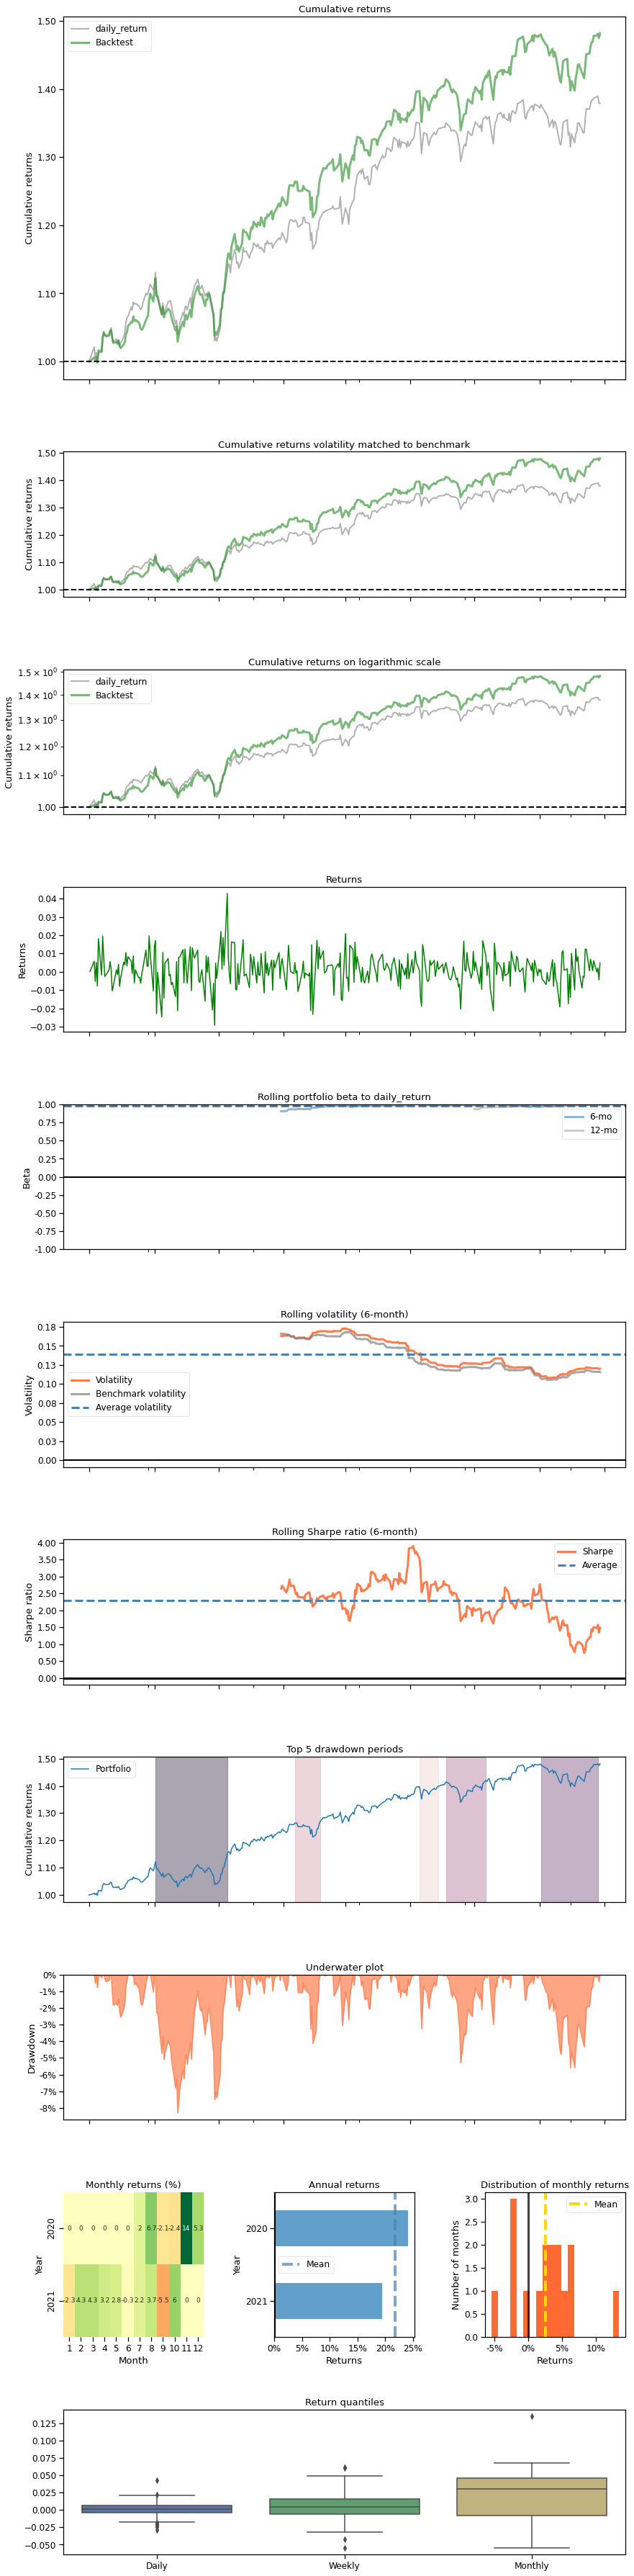

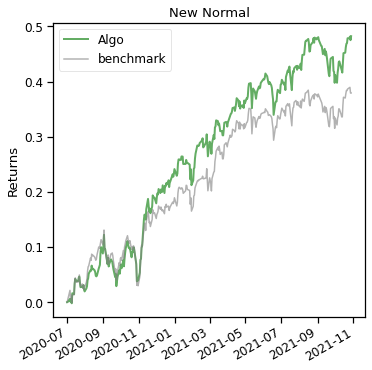

In [67]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [ ]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])